In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import date
import cpi
import matplotlib.pyplot as plt
import re
from word2number import w2n
import seaborn as sns

import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sid_obj = SentimentIntensityAnalyzer()
from collections import Counter

import ast
import matplotlib.pyplot as plt
from distutils.util import strtobool
from matplotlib import rcParams
from numpy import percentile

import pylab 
import scipy as sp
import scipy.stats as stats
import matplotlib.patches as mpatches
from numpy import median

from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    train_test_split
)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LinearRegression

#### Package setup

In [2]:
pd.set_option('display.max_rows', 400)
pd.set_option('display.max_columns', 50)

## Data Loading, Cleaning, Prepping

#### Getting Cinemascores

In [3]:
# Source: https://web.archive.org/web/20190809062201/https://www.cinemascore.com/publicsearch/index/title/
# Open HTML file
with open('data/cinemascore.txt', 'r') as f:
    cinemascore_raw = f.read()

In [4]:
# Grab movie titles and scores then save them as a dataframe
movie_title = re.findall(r'<td class="movie">(.*)<', cinemascore_raw)
scores = re.findall(r'alt="(.*)"/>', cinemascore_raw)
cinemascore = pd.DataFrame({'name' : movie_title, 'cinemascore' : scores}) 

# Clean up, sepearate year and title
cinemascore[['title','year']] = cinemascore.name.str.split("(",expand=True,)
cinemascore = cinemascore.drop("name", axis = 1)
cinemascore['year'] = cinemascore['year'].str.replace(r')', '')


altered_titles = 0
# "An" and "The" need to be move to start of the title
for i in range(len(cinemascore['title'])):
    if bool(re.search(r", AN", cinemascore['title'][i])):
        cinemascore['title'][i] = re.sub(', AN', '', cinemascore['title'][i])
        cinemascore['title'][i] = "AN "+cinemascore['title'][i]
    if bool(re.search(r", THE", cinemascore['title'][i])):
        cinemascore['title'][i] = re.sub(', THE', '', cinemascore['title'][i])
        cinemascore['title'][i] = "THE "+cinemascore['title'][i]
    # Thanks Tyler Perry for causing me to make a special exception just for your movies
    cinemascore['title'][i] = re.sub("TYLER PERRY'S ", '', cinemascore['title'][i])
    
    # remove all ":"s since they cause problems with matching
    cinemascore['title'][i] = re.sub(":", '', cinemascore['title'][i])
    
#     # if there is a ":" then make a copy row without it in case it's stored differently in the other table
#     if bool(re.search(r":", cinemascore['title'][i])):
#         cinemascore.loc[len(cinemascore) + altered_titles] = [
#                                         cinemascore['cinemascore'][i],
#                                         re.sub(":", '', cinemascore['title'][i]),
#                                         cinemascore['year'][i]
#         ]
#         altered_titles = altered_titles+1

cinemascore['title'] = cinemascore['title'].str.rstrip()
cinemascore['title'] = cinemascore['title'] + " ("+cinemascore['year']+")"

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1979680510.py:9: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  cinemascore['year'] = cinemascore['year'].str.replace(r')', '')


In [5]:
cinemascore

,cinemascore,title,year
0,B-,10 CLOVERFIELD LANE (2016),2016
1,C,"10,000 B.C. (2008)",2008
2,A,101 DALMATIANS (1996),1996
3,B+,102 DALMATIANS (2000),2000
4,B,12 MONKEYS (1995),1995
...,...,...,...
4117,B+,ZOOKEEPER (2011),2011
4118,C+,ZOOLANDER (2001),2001
4119,C+,ZOOLANDER 2 (2016),2016
4120,B-,ZOOM (2006),2006


#### Getting average movie ticket price per year table

In [6]:
# Source: https://www.natoonline.org/data/ticket-price/
# Open HTML file
with open('data/ticket_price_year.txt', 'r') as f:
    ticket_raw = f.read()

In [7]:
#ticket_raw

In [8]:
# Grab year and ticket price and save them in a table
t_year = pd.to_numeric(re.findall(r'<td class="column-1">(.*)</td><td', ticket_raw))
t_price = pd.to_numeric(re.findall(r'<td class="column-2">[$](.*)</td>', ticket_raw))
ticket_price = pd.DataFrame({'year' : t_year, 'avg_ticket_price' : t_price}) 

In [9]:
ticket_price.head(2)

,year,avg_ticket_price
0,2019,9.16
1,2018,9.11


#### Load dataset

In [171]:
movies_meta = pd.read_csv("data/movies_metadata.csv")

/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [173]:
movies_meta.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.015539,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


#### Add columns which need to be added prior to filtering the dataset

In [11]:
movies_meta['num_franchies_movies'] = 1

for i in range(len(movies_meta['belongs_to_collection'])):
    try:
        movies_meta['num_franchies_movies'][i] = re.findall(r"'id': (.+?),", movies_meta['belongs_to_collection'][i])[0]
    except:
        pass

# for i in range(len(movies_meta['belongs_to_collection'])):
#     try:
#         movies_meta['num_franchies_movies'][i] = re.findall(r"'name': '(.+?)',", movies_meta['belongs_to_collection'][i])[0]
#     except:
#         pass

franchies = Counter(movies_meta['num_franchies_movies'][movies_meta['num_franchies_movies'] != 1])

# Calculate how many franchise movies are associated with the current movie (inlcuding itself)
for i in range(len(movies_meta['num_franchies_movies'])):
    try:
        franchise_id = re.findall(r"'id': (.+?),", movies_meta['belongs_to_collection'][i])[0]
        movies_meta['num_franchies_movies'][i] = franchies[int(re.findall(r"'id': (.+?),", movies_meta['belongs_to_collection'][i])[0])]
    except:
        pass

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3163511524.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_meta['num_franchies_movies'][i] = re.findall(r"'id': (.+?),", movies_meta['belongs_to_collection'][i])[0]
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3163511524.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_meta['num_franchies_movies'][i] = franchies[int(re.findall(r"'id': (.+?),", movies_meta['belongs_to_collection'][i])[0])]


#### Clean up dataframe by removing undesired entires

In [12]:
# Remove undesired entries from database

# Remove movies unreleased at time dataset was collected
movies_meta = movies_meta[movies_meta['status'] == 'Released']

# Remove movies with less than $1,000,000 revenue
movies_meta = movies_meta[pd.to_numeric(movies_meta['revenue'], errors='coerce').notnull()] # Remove non numeric entries
movies_meta['revenue'] = movies_meta['revenue'].astype(float)
movies_meta = movies_meta[movies_meta['revenue'] > 1000000.0]

# Remove movies with less than $500,000 budget (half of revenue to avoid having a bias for flops)
movies_meta = movies_meta[pd.to_numeric(movies_meta['budget'], errors='coerce').notnull()]
movies_meta['budget'] = movies_meta['budget'].astype(float)
movies_meta = movies_meta[movies_meta['budget'] > 500000.0]

movies_meta = movies_meta.reset_index(drop=True)

#### Join imdb and cinemascore tables

In [13]:
movies_meta = movies_meta[movies_meta['release_date'].notna()].reset_index(drop=True)

# Make column with capitialized title for merging with cinemascore table later
movies_meta['title_upper'] = movies_meta['title'].str.upper()
for i in range(len(movies_meta)):
    try:
        i_year = int(str(movies_meta['release_date'][i]).split("-")[0])
        if i_year > 1880:
            movies_meta['title_upper'][i] = movies_meta['title_upper'][i] +" ("+movies_meta['release_date'][i].split("-")[0]+")"
    except:
        pass
            
    # Remove all ":"'s to standardize
    movies_meta['title_upper'][i] = re.sub(":", '', movies_meta['title_upper'][i])


movies = pd.merge(movies_meta, cinemascore, 
                   left_on = ['title_upper'],
                   right_on= ['title'], 
                   how = 'left')

movies = movies.drop("title_y", axis = 1)
movies = movies.drop("title_upper", axis = 1)
movies = movies.drop("year", axis = 1)
movies = movies.drop("video", axis = 1)
movies.rename(columns={'title_x':'title'}, inplace=True)

# Create numeric column for cinemascores
movies['cinemascore_num'] = movies['cinemascore']
rep = {'cinemascore_num': {"A+":13 , "A": 12, "A-": 11, "B+": 10, "B": 9, "B-": 8,
       "C+": 7, "C": 6, "C-": 5, "D+": 4, "D": 3, "D-": 2, "F": 1}}
movies = movies.replace(rep)

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/797538832.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_meta['title_upper'][i] = movies_meta['title_upper'][i] +" ("+movies_meta['release_date'][i].split("-")[0]+")"
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/797538832.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_meta['title_upper'][i] = re.sub(":", '', movies_meta['title_upper'][i])


In [14]:
print ("Number of properly attacheed cinemascore movies " 
       + str(len(np.where(pd.isnull(movies['cinemascore']) == False)[0])) 
       +"/"
       +str(len(cinemascore['title'].unique()))
       +' = '
       + str (len(np.where(pd.isnull(movies['cinemascore']) == False)[0]) / len(cinemascore['title'].unique()))
      )

Number of properly attacheed cinemascore movies 2402/4122 = 0.5827268316351286


#### Set correct column datatypes

In [15]:
# Convert dictionary columns from strings to actual dicts
for i in range(len(movies)):
    # Belongs to collection
    if pd.isnull(movies['belongs_to_collection'][i]) == False:
        movies['belongs_to_collection'][i] = ast.literal_eval(movies['belongs_to_collection'][i])
    
    # genres
    if pd.isnull(movies['genres'][i]) == False and movies['genres'][i] != '[]':
        movies['genres'][i] = ast.literal_eval(movies['genres'][i][1:-1])
    
    # Production companies
    if (pd.isnull(movies['production_companies'][i]) == False
       and movies['production_companies'][i] != '[]'
       and movies['production_companies'][i] != 'False'
    ):
        movies['production_companies'][i] = ast.literal_eval(movies['production_companies'][i][1:-1])
    
    # production_countries
    if pd.isnull(movies['production_countries'][i]) == False and movies['production_countries'][i] != '[]':
        movies['production_countries'][i] = ast.literal_eval(movies['production_countries'][i][1:-1])
        
    # Spoken languages
    if pd.isnull(movies['spoken_languages'][i]) == False and movies['spoken_languages'][i] != '[]':
        movies['spoken_languages'][i] = ast.literal_eval(movies['spoken_languages'][i][1:-1])
    
    # Convert release date to a datetime object
    if pd.isnull(movies['release_date'][i]) == False:
        movies['release_date'][i] = datetime.strptime(movies['release_date'][i], "%Y-%m-%d")
    
    # Convert text "true/false" to proper booleans
    movies['adult'][i] = strtobool(movies['adult'][i])


print(type(movies['belongs_to_collection'][10]))
print(type(movies['genres'][10]))
print(type(movies['production_companies'][10]))
print(type(movies['spoken_languages'][10]))
print(type(movies['release_date'][10]))

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3460966572.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['belongs_to_collection'][i] = ast.literal_eval(movies['belongs_to_collection'][i])
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3460966572.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'][i] = ast.literal_eval(movies['genres'][i][1:-1])
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3460966572.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: h

<class 'float'>
<class 'tuple'>
<class 'tuple'>
<class 'dict'>
<class 'datetime.datetime'>


In [16]:
movies = movies.astype({'adult': 'bool',
                        'id': 'int',
                        'popularity': 'float',
                        'status': 'category'})

In [17]:
movies.dtypes

adult                        bool
belongs_to_collection      object
budget                    float64
genres                     object
homepage                   object
id                          int64
imdb_id                    object
original_language          object
original_title             object
overview                   object
popularity                float64
poster_path                object
production_companies       object
production_countries       object
release_date               object
revenue                   float64
runtime                   float64
spoken_languages           object
status                   category
tagline                    object
title                      object
vote_average              float64
vote_count                float64
num_franchies_movies        int64
cinemascore                object
cinemascore_num           float64
dtype: object

#### Generate new columns

In [18]:
movies['revenue_adjusted'] = np.nan
movies['overview_sentiment'] = np.nan
movies['est_profit'] = np.nan
movies['est_profit_adjusted'] = np.nan
movies['budget_adjusted'] = np.nan
movies['est_tickets'] = np.nan
movies['returns_ratio'] = np.nan
movies['budget_tickets'] = np.nan
movies['prof_tickets'] = np.nan


for i in range(len(movies)):
    # Calculated estimated profit using the "double-budget-to-break-even" metric
    movies['est_profit'][i] = movies['revenue'][i] - movies['budget'][i]*2
    
    # Proportion of returns
    movies['returns_ratio'][i] = movies['est_profit'][i]/movies['budget'][i]
    
    i_year = movies['release_date'][i].year
    # Adjust revenue for inflation
    if i_year > 1880:
        movies['revenue_adjusted'][i] =  cpi.inflate(movies['revenue'][i],
                                                          i_year,
                                                          to=2017)
        
        movies['est_profit_adjusted'][i] =  cpi.inflate(movies['est_profit'][i],
                                                          i_year,
                                                          to=2017)
        
        movies['budget_adjusted'][i] =  cpi.inflate(movies['budget'][i],
                                                  i_year,
                                                  to=2017)
        
        movies['budget_adjusted'][i] =  cpi.inflate(movies['budget'][i],
                                          i_year,
                                          to=2017)
        
    # Calculate esitmated tickets sales based on revenue and avg ticket price for the year
    if i_year >= 1975:
        cur_ticket_price = ticket_price['avg_ticket_price'][ticket_price['year'] == i_year].iloc[0]
        ticket_sales = movies['revenue'][i] / cur_ticket_price
        movies['est_tickets'][i] = ticket_sales
        
        movies['budget_tickets'][i] = movies['budget'][i] / cur_ticket_price
        
        break_even_ticket_sales = (movies['budget'][i] * 2) / cur_ticket_price
        movies['prof_tickets'][i] = ticket_sales - break_even_ticket_sales
        
        
    # Create sentimentality score for movie description
    movies['overview_sentiment'][i] = sid_obj.polarity_scores(str(movies['overview'][i]))['compound']
    

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/2766184853.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['est_profit'][i] = movies['revenue'][i] - movies['budget'][i]*2
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/2766184853.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['returns_ratio'][i] = movies['est_profit'][i]/movies['budget'][i]
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/2766184853.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pan

#### Re-order columns

In [19]:
print(len(movies.columns))
movies.columns

35


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'num_franchies_movies', 'cinemascore', 'cinemascore_num',
       'revenue_adjusted', 'overview_sentiment', 'est_profit',
       'est_profit_adjusted', 'budget_adjusted', 'est_tickets',
       'returns_ratio', 'budget_tickets', 'prof_tickets'],
      dtype='object')

In [20]:
# reorder columns by hand to be easier to interpret
new_col_order = ['original_title', 'title', 'release_date', 'revenue', 'revenue_adjusted', 'budget', 'budget_adjusted',
                 'est_profit', 'est_profit_adjusted', 'returns_ratio', 'est_tickets', 'budget_tickets', 'prof_tickets', 'vote_count',
                 'vote_average', 'cinemascore', 'cinemascore_num', 'genres', 'runtime', 'belongs_to_collection',
                 'num_franchies_movies', 'original_language',
                 'spoken_languages', 'production_countries', 'production_companies', 'overview',
                 'overview_sentiment', 'tagline', 'status', 'popularity', 'id', 'imdb_id', 
                 'homepage', 'poster_path']
print(len(new_col_order))

# Popularity re-calculated to be weekly popularity so it's a bad metric

movies = movies[new_col_order]

34


In [21]:
#movies.iloc[np.where(pd.isnull(  movies['cinemascore']  ))[0]].head(50).sort_values(by=['revenue'], ascending = False)

In [186]:
movies.sort_values(by=['revenue_adjusted'], ascending = False).head(20)

,original_title,title,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path
284,Gone with the Wind,Gone with the Wind,1939-12-15 00:00:00,4.001765e+08,7.056925e+09,4000000.0,7.053813e+07,3.921765e+08,6.915848e+09,98.044115,NaN,NaN,NaN,995.0,7.7,NaN,NaN,"({'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",238.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'Selznick International Pictures', '...",An American classic in which a manipulative wo...,0.0772,The greatest romance of all time!,Released,14.240357,770,tt0031381,NaN,/4o1yeosjSFMaI9pe1rOkYcZ6hHO.jpg
317,Alice in Wonderland,Alice in Wonderland,1951-07-03 00:00:00,5.720000e+08,5.392640e+09,3000000.0,2.828308e+07,5.660000e+08,5.336074e+09,188.666667,NaN,NaN,NaN,1557.0,7.0,NaN,NaN,"({'id': 16, 'name': 'Animation'}, {'id': 12, '...",75.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'RKO Radio Pictures', 'id': 6}, {'na...","On a golden afternoon, young Alice follows a W...",0.8881,A world of wonders in One Great Picture,Released,16.488937,12092,tt0043274,NaN,/9gJa2B6M8jt85aDkb0MF98MLZ9T.jpg
669,Bambi,Bambi,1942-08-14 00:00:00,2.674472e+08,4.021880e+09,858000.0,1.290264e+07,2.657312e+08,3.996075e+09,309.709965,NaN,NaN,NaN,1450.0,6.8,NaN,NaN,"({'id': 16, 'name': 'Animation'}, {'id': 18, '...",70.0,"{'id': 87250, 'name': 'Bambi Collection', 'pos...",2,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","{'name': 'Walt Disney Productions', 'id': 3166}",Bambi's tale unfolds from season to season as ...,0.8074,A great love story.,Released,13.698132,3170,tt0034492,http://movies.disney.com/bambi,/laABfcpEKweQsaZwCWzmGNUpij9.jpg
3142,Avatar,Avatar,2009-12-10 00:00:00,2.787965e+09,3.185399e+09,237000000.0,2.707852e+08,2.313965e+09,2.643829e+09,9.763566,3.717287e+08,3.160000e+07,3.085287e+08,12114.0,7.2,A,12.0,"({'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",162.0,"{'id': 87096, 'name': 'Avatar Collection', 'po...",2,en,"({'iso_639_1': 'en', 'name': 'English'}, {'iso...","({'iso_3166_1': 'US', 'name': 'United States o...","({'name': 'Ingenious Film Partners', 'id': 289...","In the 22nd century, a paraplegic Marine is di...",-0.3612,Enter the World of Pandora.,Released,185.070892,19995,tt0499549,http://www.avatarmovie.com/,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg
206,Snow White and the Seven Dwarfs,Snow White and the Seven Dwarfs,1937-12-20 00:00:00,1.849255e+08,3.147843e+09,1488423.0,2.533627e+07,1.819486e+08,3.097170e+09,122.242561,NaN,NaN,NaN,1973.0,6.9,NaN,NaN,"({'id': 14, 'name': 'Fantasy'}, {'id': 16, 'na...",83.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","{'name': 'Walt Disney Productions', 'id': 3166}","A beautiful girl, Snow White, takes refuge in ...",0.1531,"The Happiest, Dopiest, Grumpiest, Sneeziest mo...",Released,16.263878,408,tt0029583,http://movies.disney.com/snow-white-and-the-se...,/wbVGRBYPRRahIZNGXY9TfHDUSc2.jpg
93,Star Wars,Star Wars,1977-05-25 00:00:00,7.753980e+08,3.136395e+09,11000000.0,4.449373e+07,7.533980e+08,3.047408e+09,68.490728,3.477121e+08,4.932735e+06,3.378466e+08,6778.0,8.1,NaN,NaN,"({'id': 12, 'name': 'Adventure'}, {'id': 28, '...",121.0,"{'id': 10, 'name': 'Star Wars Collection', 'po...",8,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'Lucasfilm', 'id': 1}, {'name': 'Twe...",Princess Leia is captured and held hostage by ...,0.8979,"A long time ago in a galaxy far, far away...",Released,42.149697,11,tt0076759

## Correlation plot

In [23]:
movies.head(2)

,original_title,title,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path
0,Toy Story,Toy Story,1995-10-30 00:00:00,373554033.0,6.008239e+08,30000000.0,4.825197e+07,313554033.0,5.043200e+08,10.451801,8.587449e+07,6.896552e+06,7.208139e+07,5415.0,7.7,A,12.0,"({'id': 16, 'name': 'Animation'}, {'id': 35, '...",81.0,"{'id': 10194, 'name': 'Toy Story Collection', ...",3,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","{'name': 'Pixar Animation Studios', 'id': 3}","Led by Woody, Andy's toys live happily in his ...",0.4767,NaN,Released,21.946943,862,tt0114709,http://toystory.disney.com/toy-story,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg
1,Jumanji,Jumanji,1995-12-15 00:00:00,262797249.0,4.226828e+08,65000000.0,1.045459e+08,132797249.0,2.135910e+08,2.043035,6.041316e+07,1.494253e+07,3.052810e+07,2413.0,6.9,A-,11.0,"({'id': 12, 'name': 'Adventure'}, {'id': 14, '...",104.0,NaN,1,en,"({'iso_639_1': 'en', 'name': 'English'}, {'iso...","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'TriStar Pictures', 'id': 559}, {'na...",When siblings Judy and Peter discover an encha...,-0.4588,Roll the dice and unleash the excitement!,Released,17.015539,8844,tt0113497,NaN,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg


In [24]:
movies_corr_values = movies.drop(['original_title', 'title', 'release_date', 'cinemascore', 'genres',
                                'belongs_to_collection', 'spoken_languages', 'production_companies', 
                                'overview', 'tagline', 'status', 'popularity', 'id', 'imdb_id', 'homepage',
                                'poster_path'], axis = 1)

movies_corr_values['in_english'] = False
movies_corr_values['from_usa'] = False

# Replace language with true/false for english
for i in range(len(movies_corr_values)):
    if movies_corr_values['original_language'][i] == 'en':
        movies_corr_values['in_english'][i] = True
    
    # extract country. Multi-country movies are stored as tuples of dicts. Single country = single dict.
    if type(movies_corr_values['production_countries'][i]) == dict:
        if movies_corr_values['production_countries'][i].get("name") == "United States of America":
                movies_corr_values['from_usa'][i] = True
    elif type(movies_corr_values['production_countries'][i]) == tuple:
        for countries in movies_corr_values['production_countries'][i]:
            if countries.get("name") == "United States of America":
                movies_corr_values['from_usa'][i] = True

    
movies_corr_values = movies_corr_values.drop(["original_language", "production_countries"], axis =1)
movies_corr_values.reset_index(drop = True,  inplace=True)

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3928746773.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_corr_values['in_english'][i] = True
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3928746773.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_corr_values['from_usa'][i] = True
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3928746773.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [26]:
movies_corr_values.dtypes

revenue                 float64
revenue_adjusted        float64
budget                  float64
budget_adjusted         float64
est_profit              float64
est_profit_adjusted     float64
returns_ratio           float64
est_tickets             float64
budget_tickets          float64
prof_tickets            float64
vote_count              float64
vote_average            float64
cinemascore_num         float64
runtime                 float64
num_franchies_movies      int64
overview_sentiment      float64
in_english                 bool
from_usa                   bool
dtype: object

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/2616769400.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(movies_corr, dtype=np.bool))


<AxesSubplot:>

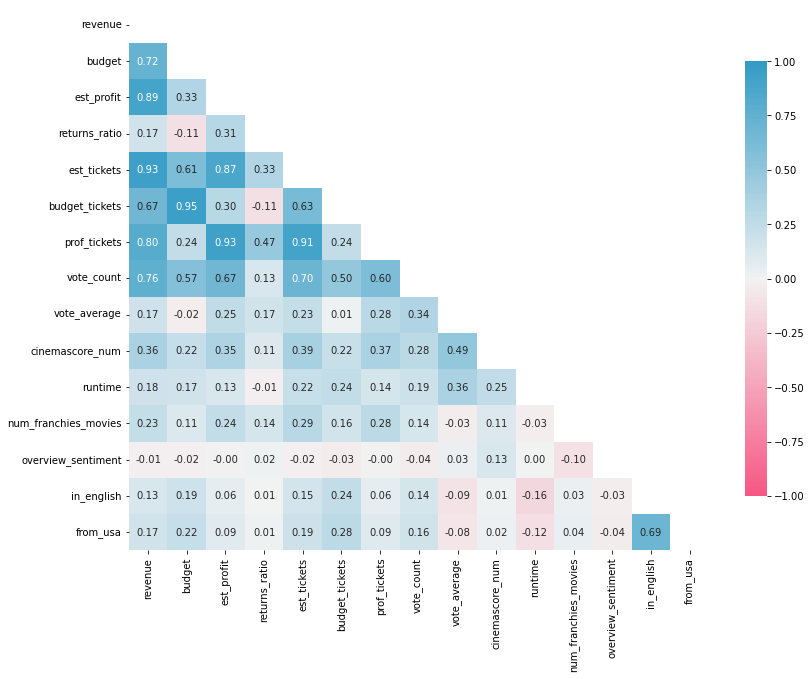

In [27]:
movies_corr_unadjusted = movies_corr_values.drop(['revenue_adjusted', 'budget_adjusted', 'est_profit_adjusted'], axis = 1)

movies_corr = movies_corr_unadjusted.corr(method ='pearson')
mask = np.triu(np.ones_like(movies_corr, dtype=np.bool))


fig, ax = plt.subplots(figsize=(13,10)) 

cmap = sns.diverging_palette(0, 230, 90, 60, as_cmap=True)
sns.heatmap(movies_corr, mask=mask, annot=True, fmt=".2f", cmap=cmap,
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})

#plt.imshow(movies_corr, cmap='hot', interpolation='nearest')


### Prepping data for linear relationship graphs

In [28]:
cinemascore_only = movies

# Drop movies from before 1997
drop_columns = []
for i in range(len(cinemascore_only)):
    if cinemascore_only.release_date[i].year < 1997:
        drop_columns.append(i)
cinemascore_only = cinemascore_only.drop(cinemascore_only.index[drop_columns])

# Make copy for creating scattplot B later
imdb_scoring = cinemascore_only.reset_index(drop=True) 

# Remove rows with no cinemascore
cinemascore_only = cinemascore_only[cinemascore_only['cinemascore'].notna()]
cinemascore_only = cinemascore_only.reset_index(drop=True) 

# Make new column to hold the grade only (A/B/C/D/F)
cinemascore_only['cinemascore_grade'] = np.nan
for i in range(len(cinemascore_only['cinemascore_grade'])):
    cinemascore_only['cinemascore_grade'][i] = str(cinemascore_only['cinemascore'][i])
    cinemascore_only['cinemascore_grade'][i] = cinemascore_only['cinemascore_grade'][i][0]

cinemascore_only = cinemascore_only.sort_values(by=['cinemascore_grade'], ascending = True)
cinemascore_only = cinemascore_only.reset_index(drop=True)


# Create numeric column for cinemascores grouped to be roughly the same size
cinemascore_only['cinemascore_rank'] = cinemascore_only['cinemascore']
rep = {'cinemascore_rank': {"A+": 1, "A": 1, "A-": 2, "B+": 3, "B": 4, "B-": 4,
       "C+": 5, "C": 5, "C-": 5, "D+": 5, "D": 5, "D-": 5, "F": 5}}
cinemascore_only = cinemascore_only.replace(rep)


# Remove outliers
q1 = cinemascore_only['revenue'].quantile(0.25)
q3 = cinemascore_only['revenue'].quantile(0.75)
iqr = q3-q1
low  = q1-1.5*iqr
high = q3+1.5*iqr
cinemascore_only_no_outlier = cinemascore_only.loc[(cinemascore_only['revenue'] > low) & (cinemascore_only['revenue'] < high)]

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/870468993.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cinemascore_only['cinemascore_grade'][i] = str(cinemascore_only['cinemascore'][i])
/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


1918


In [184]:
print(len(cinemascore_only)/len(imdb_scoring))

0.5787567893783947


In [29]:
pd.DataFrame(cinemascore_only['cinemascore'].value_counts(normalize=True))

,cinemascore
B+,0.202294
A-,0.201251
B,0.166840
B-,0.123566
A,0.111053
C+,0.079771
C,0.039625
C-,0.032325
A+,0.015641
D+,0.011992


In [30]:
# Create column of the brackets for the different movie scores
imdb_scoring['vote_bracket'] = np.nan

vote_percentiles = percentile(imdb_scoring['vote_average'], [20, 40, 60, 80])

for i in range(len(imdb_scoring)):
    if imdb_scoring['vote_average'][i] >= vote_percentiles[3]:
        imdb_scoring['vote_bracket'][i] = 1
    elif imdb_scoring['vote_average'][i] >= vote_percentiles[2]:
        imdb_scoring['vote_bracket'][i] = 2
    elif imdb_scoring['vote_average'][i] >= vote_percentiles[1]:
        imdb_scoring['vote_bracket'][i] = 3
    elif imdb_scoring['vote_average'][i] >= vote_percentiles[0]:
        imdb_scoring['vote_bracket'][i] = 4
    else:
        imdb_scoring['vote_bracket'][i] = 5

# Remove outliers
q1 = imdb_scoring['revenue'].quantile(0.25)
q3 = imdb_scoring['revenue'].quantile(0.75)
iqr = q3-q1
low  = q1-1.5*iqr
high = q3+1.5*iqr
imdb_scoring_no_outlier = imdb_scoring.loc[(imdb_scoring['revenue'] > low) & (imdb_scoring['revenue'] < high)]

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/4145261030.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_scoring['vote_bracket'][i] = 4
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/4145261030.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_scoring['vote_bracket'][i] = 5
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/4145261030.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-v

In [31]:
imdb_scoring.head(2)

,original_title,title,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,vote_bracket
0,The Relic,The Relic,1997-01-10 00:00:00,33956608.0,5.185946e+07,60000000.0,9.163364e+07,-86043392.0,-1.314078e+08,-1.434057,7.397954e+06,1.307190e+07,-1.874584e+07,130.0,5.8,B-,8.0,"({'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","({'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","({'name': 'Paramount Pictures', 'id': 4}, {'na...",A researcher at Chicago's Natural History Muse...,-0.802,The Next Evolution In Terror.,Released,7.699967,11015,tt0120004,NaN,/jD853TWyJYuksMldrFWaXMovRg0.jpg,4.0
1,Shadow Conspiracy,Shadow Conspiracy,1997-01-31 00:00:00,2154540.0,3.290473e+06,45000000.0,6.872523e+07,-87845460.0,-1.341600e+08,-1.952121,4.693987e+05,9.803922e+06,-1.913844e+07,12.0,4.0,NaN,NaN,"({'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",103.0,NaN,1,en,"({'iso_639_1': 'en', 'name': 'English'}, {'iso...","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'Hollywood Pictures', 'id': 915}, {'...",Bobby Bishop (Sheen) is a special assistant to...,-0.802,NaN,Released,3.733574,38153,tt0120107,NaN,/w1MCRsbCAIdOTobSmoU9KIEvZKF.jpg,5.0


### QQ Plots to check the distribution of each of our metrics

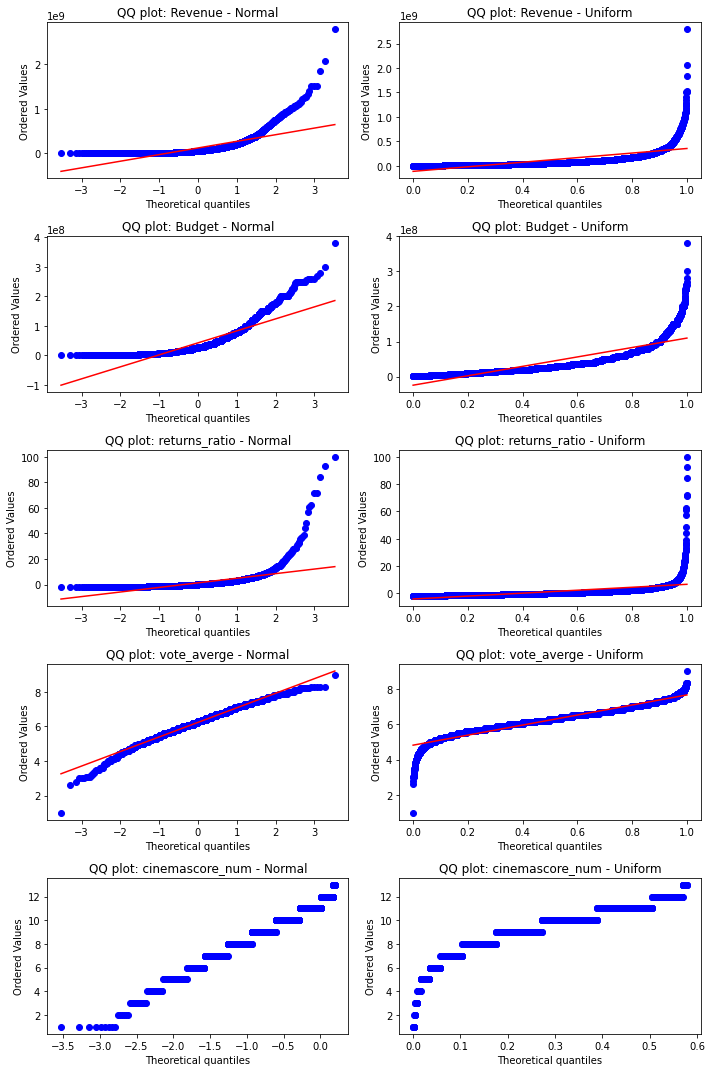

In [32]:
fig, ax = plt.subplots(5,2, figsize=(10,15))

stats.probplot(imdb_scoring['revenue'], dist="norm", plot=ax[0, 0])
ax[0, 0].title.set_text('QQ plot: Revenue - Normal')
stats.probplot(imdb_scoring['revenue'], dist="uniform", plot=ax[0, 1])
ax[0, 1].title.set_text('QQ plot: Revenue - Uniform')

stats.probplot(imdb_scoring['budget'], dist="norm", plot=ax[1, 0])
ax[1, 0].title.set_text('QQ plot: Budget - Normal')
stats.probplot(imdb_scoring['budget'], dist="uniform", plot=ax[1, 1])
ax[1, 1].title.set_text('QQ plot: Budget - Uniform')

stats.probplot(imdb_scoring['returns_ratio'], dist="norm", plot=ax[2, 0])
ax[2, 0].title.set_text('QQ plot: returns_ratio - Normal')
stats.probplot(imdb_scoring['returns_ratio'], dist="uniform", plot=ax[2, 1])
ax[2, 1].title.set_text('QQ plot: returns_ratio - Uniform')

stats.probplot(imdb_scoring['vote_average'], dist="norm", plot=ax[3, 0])
ax[3, 0].title.set_text('QQ plot: vote_averge - Normal')
stats.probplot(imdb_scoring['vote_average'], dist="uniform", plot=ax[3, 1])
ax[3, 1].title.set_text('QQ plot: vote_averge - Uniform')

stats.probplot(imdb_scoring['cinemascore_num'], dist="norm", plot=ax[4, 0])
ax[4, 0].title.set_text('QQ plot: cinemascore_num - Normal')
stats.probplot(imdb_scoring['cinemascore_num'], dist="uniform", plot=ax[4, 1])
ax[4, 1].title.set_text('QQ plot: cinemascore_num - Uniform')

fig.tight_layout()

### Correlation

#### Cinemascore vs IMDb Score

##### Check if they are the same with a t test

In [33]:
# Dive ticket sales into 4 quantiles
c_25 = cinemascore_only['cinemascore_num'].quantile(0.25)
c_50 = cinemascore_only['cinemascore_num'].quantile(0.50)
c_75 = cinemascore_only['cinemascore_num'].quantile(0.75)
i_25 = imdb_scoring['vote_average'].quantile(0.25)
i_50 = imdb_scoring['vote_average'].quantile(0.50)
i_75 = imdb_scoring['vote_average'].quantile(0.75)

cinema_bot = cinemascore_only[cinemascore_only['cinemascore_num'] <= c_25]['est_tickets']
cinema_low = cinemascore_only[(cinemascore_only['cinemascore_num'] > c_25) & (cinemascore_only['cinemascore_num'] <= c_50)]['est_tickets']
cinema_mid = cinemascore_only[(cinemascore_only['cinemascore_num'] > c_50) & (cinemascore_only['cinemascore_num'] <= c_75)]['est_tickets']
cinema_high = cinemascore_only[(cinemascore_only['cinemascore_num'] > c_75)]['est_tickets']

imdb_bot = imdb_scoring[imdb_scoring['vote_average'] <= i_25]['est_tickets']
imdb_low = imdb_scoring[(imdb_scoring['vote_average'] > i_25) & (imdb_scoring['vote_average'] <= i_50)]['est_tickets']
imdb_mid = imdb_scoring[(imdb_scoring['vote_average'] > i_50) & (imdb_scoring['vote_average'] <= i_75)]['est_tickets']
imdb_high = imdb_scoring[(imdb_scoring['vote_average'] > i_75)]['est_tickets']

In [34]:
print(np.var(cinema_bot)/np.var(imdb_bot))
print(np.var(cinema_low)/np.var(imdb_low))
print(np.var(cinema_mid)/np.var(imdb_mid))
print(np.var(cinema_high)/np.var(imdb_high))

0.7132284049678973
0.9749868627209028
1.2250465933944705
1.887659822856404


In [35]:
# All pairs have a variance between 0.25 and 4 so we can say that there is equal variance in both groups

t_test_pairs = [[cinema_bot, imdb_bot], [cinema_low, imdb_low], [cinema_mid, imdb_mid], [cinema_high, imdb_high]]
t_tests = [['25th Percentile and Lower'], ['25th to 50th Percentile'], ['50th to 75 Percentile'], ['75th Percentile and Above']]

loop_index = 0
for i in t_test_pairs:
    print(t_tests[loop_index])
    loop_index = loop_index+1
    print(stats.ttest_ind(a=i[0], b=i[1], equal_var=True))
    print('\n')

['25th Percentile and Lower']
Ttest_indResult(statistic=0.3202948658441649, pvalue=0.7487908997905153)


['25th to 50th Percentile']
Ttest_indResult(statistic=4.091192181676274, pvalue=4.5022553599862096e-05)


['50th to 75 Percentile']
Ttest_indResult(statistic=6.981013302027496, pvalue=4.982989268531741e-12)


['75th Percentile and Above']
Ttest_indResult(statistic=8.422314872128963, pvalue=1.243551694582997e-16)




P values are below 0.05 for 25th percentile and up so we have sufficient evidence to say that the same population is not represented by cinemascore and imdb_score

However, 25th percentile and lower has a p_value of 0.70 (cannot reject null hypothesis) so we do not have sufficent evidence to say that the this popuation is different

##### **Conclusion: both populations are not the same for anything but the bottom 25% of movies**

#### Comparing Cinemascore and IMDb Score With Linear Models

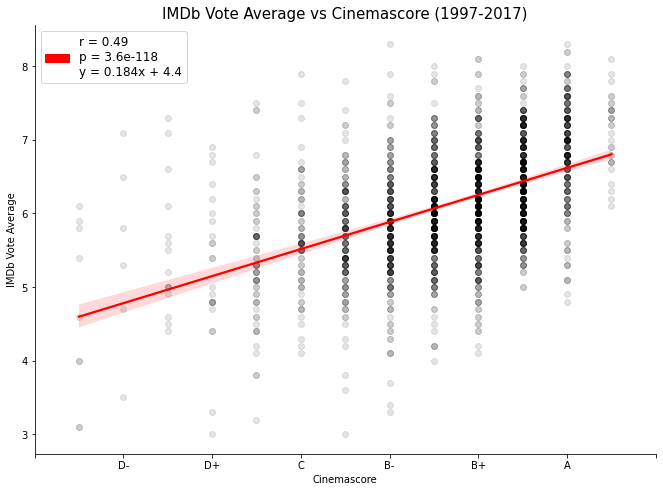

In [36]:
# IMDB Score vs Cinemascore
g = sns.lmplot(x="cinemascore_num", y="vote_average", data=cinemascore_only,
               scatter_kws={'alpha':0.10, "color": "black"},
               line_kws={'color': 'red'})

g.fig.set_size_inches(10,7)
g.set(xlabel='Cinemascore', ylabel='IMDb Vote Average')
g.set_xticklabels(['','D-','D+','C','B-', 'B+', 'A', ''])
plt.title("IMDb Vote Average vs Cinemascore (1997-2017)", fontdict={'size': 15})

# Generate legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(cinemascore_only['cinemascore_num'], cinemascore_only['vote_average'])
legend_text = mpatches.Patch(color='red', label='r = {:.2f}\np = {:.2g}\ny = {:.3g}x + {:.2g}'.format(r_value, p_value, slope, intercept),)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1616981899.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(['','D-','D+','C','B-', 'B+', 'A', ''])
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1616981899.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


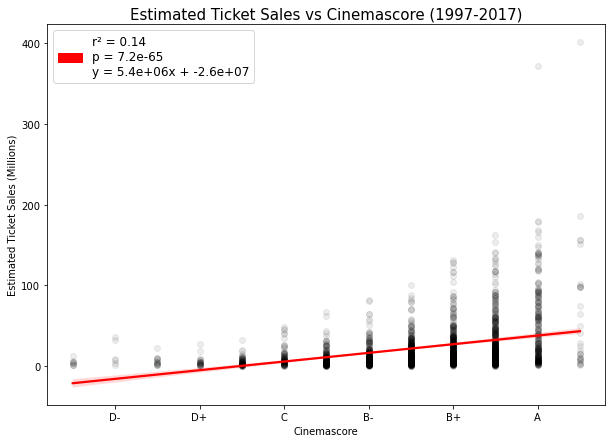

In [37]:
#Estimated Ticket Sales vs Cinemascore
plt.figure(figsize=(10,7))

g = sns.regplot(x="cinemascore_num", y="est_tickets", data=cinemascore_only,
          scatter_kws={'alpha':0.07, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )
plt.title("Estimated Ticket Sales vs Cinemascore (1997-2017)", fontdict={'size': 15})

g.set_xticklabels(['','D-','D+','C','B-', 'B+', 'A', ''])
g.set(xlabel='Cinemascore', ylabel='Estimated Ticket Sales (Millions)')

ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(cinemascore_only['cinemascore_num'], cinemascore_only['est_tickets'])
legend_text = mpatches.Patch(color='red', label='r\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept),)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/2579062725.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


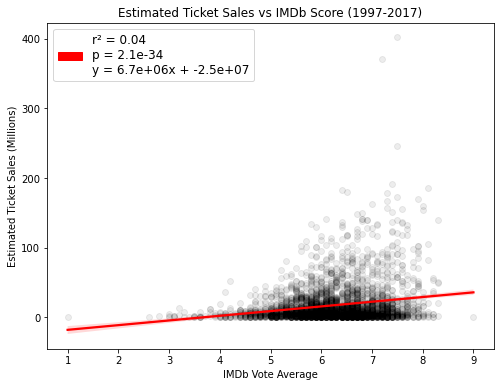

In [38]:
# Estimated Ticket Sales vs IMDB Score
plt.figure(figsize=(8,6))
plt.title("Estimated Ticket Sales vs IMDb Score (1997-2017)", fontdict={'size': 12})

g = sns.regplot(x="vote_average", y="est_tickets", data=imdb_scoring,
          scatter_kws={'alpha':0.07, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )

g.set(xlabel='IMDb Vote Average', ylabel='Estimated Ticket Sales (Millions)')
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['vote_average'], imdb_scoring['est_tickets'])
legend_text = mpatches.Patch(color='red', label='r\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept),)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3525967852.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3525967852.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)


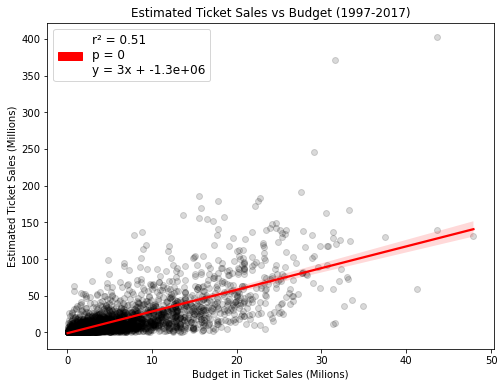

In [39]:
# Estimated Ticket Sales vs Budget
plt.figure(figsize=(8,6))
plt.title("Estimated Ticket Sales vs Budget (1997-2017)", fontdict={'size': 12})

g = sns.regplot(x="budget_tickets", y="est_tickets", data=imdb_scoring,
          scatter_kws={'alpha':0.15, "color": "black"},
          line_kws={'color': 'red', 'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)}
    )

g.set(xlabel='Budget in Ticket Sales (Milions)', ylabel='Estimated Ticket Sales (Millions)')
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()/1e6]
g.set_yticklabels(ylabels)
xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()/1e6]
g.set_xticklabels(xlabels)

# Legend
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['budget_tickets'], imdb_scoring['est_tickets'])
ticket_budget_label = 'r\u00b2 = {:.2f}\np = {:.2g}\ny = {:.2g}x + {:.2g}'.format(r_value**2, p_value, slope, intercept)
legend_text = mpatches.Patch(color='red', label=ticket_budget_label,)
plt.legend(loc='upper left', fontsize = 12, handles=[legend_text])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1447666774.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1447666774.py:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


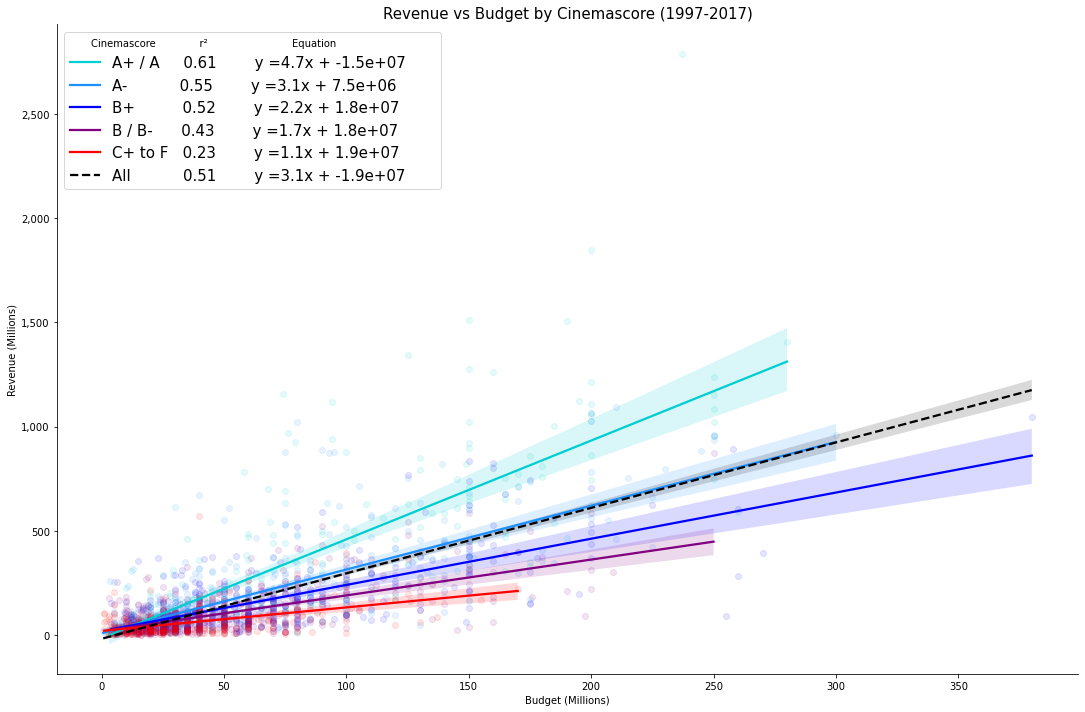

In [40]:
# Revenue vs Budget by Cinemascore
g = sns.lmplot(x="budget", y="revenue", hue="cinemascore_rank", data=cinemascore_only,
          palette=['darkturquoise','dodgerblue','blue','purple', 'red'],
          scatter_kws={'alpha':0.1},
          legend = False
    )

overall_line = sns.regplot(x='budget', y='revenue', data=cinemascore_only, 
            ax=g.axes.flat[0], 
            color="black",
            label='Overall',
            scatter=False,
            ci=68,
            line_kws={'ls':'--'}
            )

g.fig.set_size_inches(15,10)
plt.title("Revenue vs Budget by Cinemascore (1997-2017)", fontdict={'size': 15})

# Runs for each line to calculate statistics
l_stat = []
def annotate(data, **kws):
    slope, intercept, r, p, std_err = sp.stats.linregress(data['budget'], data['revenue'])
    slope_eq = 'y ={:.1f}x + {:.2g}'.format(slope, intercept),
    r_2 = '{:.2f}'.format(r**2)
    l_stat.append([r_2, slope_eq])
g.map_dataframe(annotate) 

# Get overall line stats
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(cinemascore_only['budget'], cinemascore_only['revenue'])
r_2 = '{:.2f}'.format(r_value**2)
slope_eq = 'y ={:.1f}x + {:.2g}'.format(slope, intercept)

# Legend
plt.legend(title='Cinemascore              r\u00b2                           Equation                         ',
           loc='upper left', prop={'size': 15},
           labels=['A+ / A     {}        {}      '.format(l_stat[0][0], l_stat[0][1][0]),
                   'A-           {}        {}      '.format(l_stat[1][0], l_stat[1][1][0]),
                   'B+          {}        {}      '.format(l_stat[2][0], l_stat[2][1][0]),
                   'B / B-      {}        {}      '.format(l_stat[3][0], l_stat[3][1][0]),
                   'C+ to F   {}        {}      '.format(l_stat[4][0], l_stat[4][1][0]),
                   'All           {}        {}      '.format(r_2, slope_eq)
            ]
          )

# Needed to change properties of plot since we're using "hue" to have multiple groups
for ax in g.axes.flat:
    ylabels = ['{:,.0f}'.format(x) for x in ax.get_yticks()/1e6]
    ax.set_yticklabels(ylabels)
    xlabels = ['{:,.0f}'.format(x) for x in ax.get_xticks()/1e6]
    ax.set_xticklabels(xlabels)
    g.set(xlabel='Budget (Millions)', ylabel='Revenue (Millions)')

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1176865206.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1176865206.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


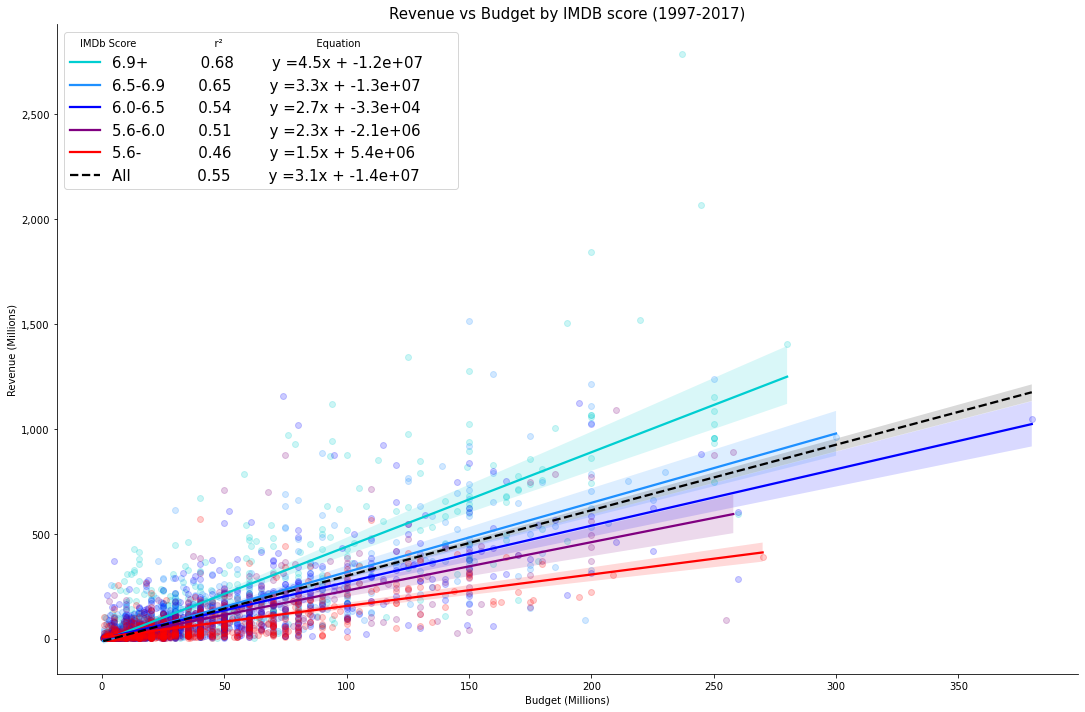

In [41]:
# Revenue vs Budget by IMDB score
g = sns.lmplot(x="budget", y="revenue", hue="vote_bracket", data=imdb_scoring,
          palette=['darkturquoise','dodgerblue','blue','purple', 'red'],
          scatter_kws={'alpha':0.2},
          legend = False
    )

overall_line = sns.regplot(x='budget', y='revenue', data=imdb_scoring, 
            ax=g.axes.flat[0], 
            color="black",
            label='Overall',
            scatter=False,
            ci=68,
            line_kws={'ls':'--'}
            )

g.fig.set_size_inches(15,10)
plt.title("Revenue vs Budget by IMDB score (1997-2017)", fontdict={'size': 15})

# Runs for each line to calculate statistics
l_stat = []
def annotate(data, **kws):
    slope, intercept, r, p, std_err = sp.stats.linregress(data['budget'], data['revenue'])
    slope_eq = 'y ={:.1f}x + {:.2g}'.format(slope, intercept),
    r_2 = '{:.2f}'.format(r**2)
    l_stat.append([r_2, slope_eq])
g.map_dataframe(annotate) 

# Get overall line stats
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(imdb_scoring['budget'], imdb_scoring['revenue'])
r_2 = '{:.2f}'.format(r_value**2)
slope_eq = 'y ={:.1f}x + {:.2g}'.format(slope, intercept)


plt.legend(title='IMDb Score                         r\u00b2                              Equation                          ',
           loc='upper left', prop={'size': 15},
           labels=['6.9+           {}        {}      '.format(l_stat[0][0], l_stat[0][1][0]),
                   '6.5-6.9       {}        {}      '.format(l_stat[1][0], l_stat[1][1][0]),
                   '6.0-6.5       {}        {}      '.format(l_stat[2][0], l_stat[2][1][0]),
                   '5.6-6.0       {}        {}      '.format(l_stat[3][0], l_stat[3][1][0]),
                   '5.6-            {}        {}      '.format(l_stat[4][0], l_stat[4][1][0]),
                   'All              {}        {}      '.format(r_2, slope_eq)
            ]
          )


# Needed to change properties of plot since we're using "hue" to have multiple groups
for ax in g.axes.flat:
    ylabels = ['{:,.0f}'.format(x) for x in ax.get_yticks()/1e6]
    ax.set_yticklabels(ylabels)
    xlabels = ['{:,.0f}'.format(x) for x in ax.get_xticks()/1e6]
    ax.set_xticklabels(xlabels)
    g.set(xlabel='Budget (Millions)', ylabel='Revenue (Millions)')

#### Revenue vs Budget by IMDB rating

In [42]:
vote_percentiles

array([5.6, 6. , 6.5, 7. ])

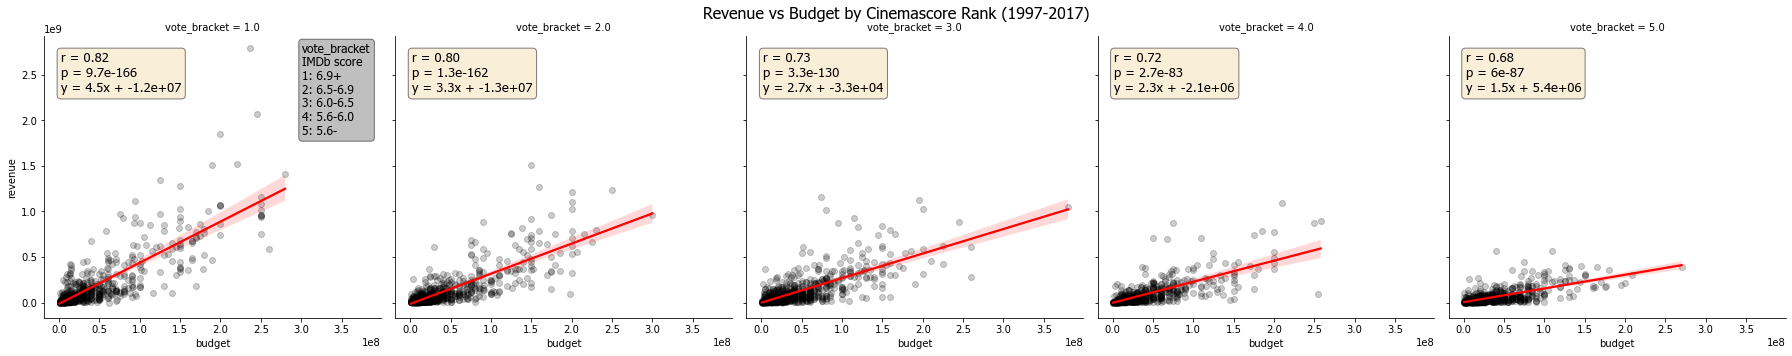

In [43]:
g = sns.lmplot(x='budget', y='revenue', data=imdb_scoring,
               col='vote_bracket', height=5, aspect=1,
               scatter_kws={'alpha':0.2, 'color': 'black'},
               line_kws={'color': 'red'})

plt.rcParams['font.family'] = 'Tahoma'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['budget'], data['revenue'])
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data['budget'], data['revenue'])
    ax = plt.gca()
    ax.text(.05, .8, 'r = {:.2f}\np = {:.2g}\ny = {:.1f}x + {:.2g}'.format(r, p, slope, intercept),
            transform=ax.transAxes,fontsize=13,  bbox=props )
    
g.map_dataframe(annotate) # Runs for each row

# Add title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Revenue vs Budget by Cinemascore Rank (1997-2017)', fontsize=16)

# Add legend for different columns
txtlabels='vote_bracket\nIMDb score\n1: 6.9+\n2: 6.5-6.9\n3: 6.0-6.5\n4: 5.6-6.0\n5: 5.6-'
props2 = dict(boxstyle='round', facecolor='grey', alpha=0.5)
g.fig.text(0.17, 0.88, txtlabels, fontsize=12,verticalalignment='top', bbox=props2)

plt.show()

In [44]:
cinemascore_only.head(1)

,original_title,title,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,cinemascore_grade,cinemascore_rank
0,Role Models,Role Models,2008-02-03 00:00:00,92380927.0,1.051746e+08,28000000.0,3.187768e+07,36380927.0,4.141927e+07,1.299319,1.286642e+07,3.899721e+06,5.066981e+06,575.0,6.4,A-,11.0,"{'id': 35, 'name': 'Comedy'}",99.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'Universal Pictures', 'id': 33}, {'n...",Two salesmen trash a company truck on an energ...,0.2846,They're about to get more than they plea-barga...,Released,7.646215,15373,tt0430922,NaN,/bq6wxu0rv1GIkEwslBT2rVgLkxe.jpg,A,2


#### Revenue vs Budget by Cinemascore Rank

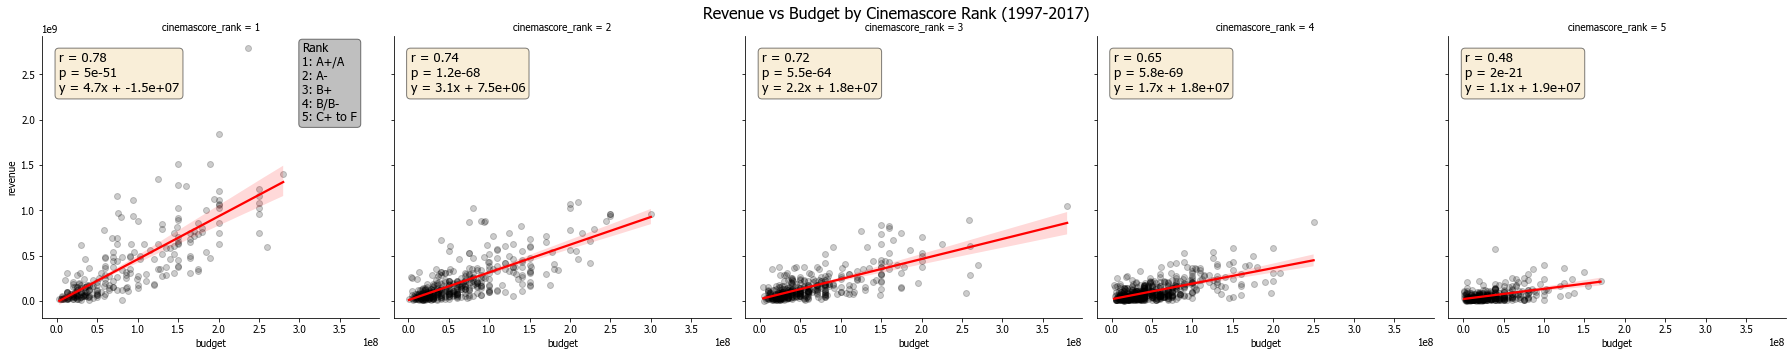

In [45]:
g = sns.lmplot(x='budget', y='revenue', data=cinemascore_only,
               col='cinemascore_rank', height=5, aspect=1,
               scatter_kws={'alpha':0.2, 'color': 'black'},
               line_kws={'color': 'red'})

plt.rcParams['font.family'] = 'Tahoma'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['budget'], data['revenue'])
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data['budget'], data['revenue'])
    ax = plt.gca()
    ax.text(.05, .8, 'r = {:.2f}\np = {:.2g}\ny = {:.1f}x + {:.2g}'.format(r, p, slope, intercept),
            transform=ax.transAxes,fontsize=13,  bbox=props )
    
g.map_dataframe(annotate) # Runs for each row

# Add title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Revenue vs Budget by Cinemascore Rank (1997-2017)', fontsize=16)

# Add legend for different columns
txtlabels='Rank\n1: A+/A\n2: A-\n3: B+\n4: B/B-\n5: C+ to F'
props2 = dict(boxstyle='round', facecolor='grey', alpha=0.5)
g.fig.text(0.17, 0.88, txtlabels, fontsize=12,verticalalignment='top', bbox=props2)

plt.show()

#### Revenue vs Budget by IMDb Voting Bracket

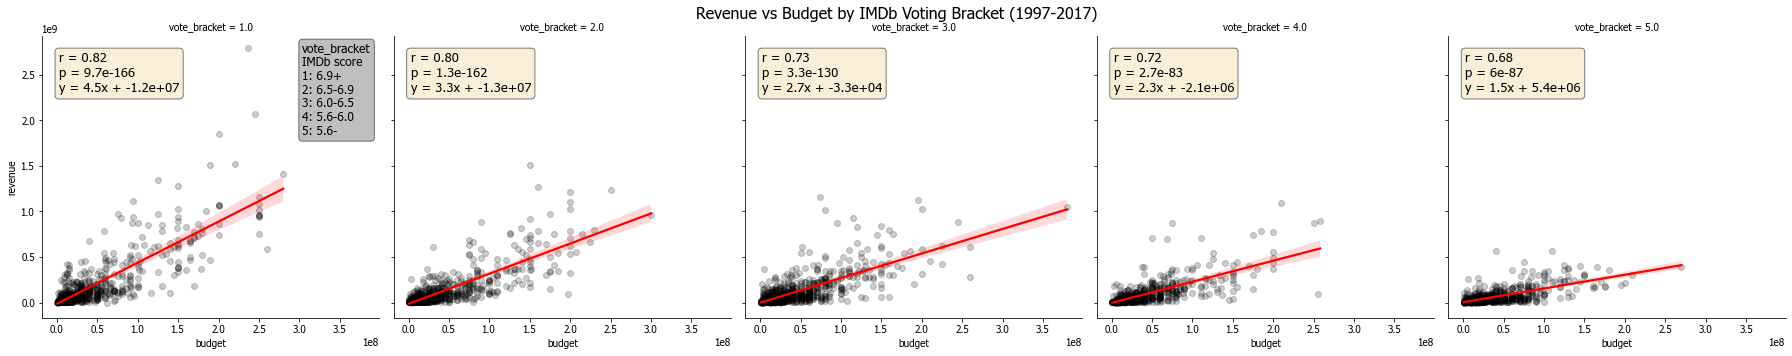

In [46]:
g = sns.lmplot(x='budget', y='revenue', data=imdb_scoring,
               col='vote_bracket', height=5, aspect=1,
               scatter_kws={'alpha':0.2, 'color': 'black'},
               line_kws={'color': 'red'})

plt.rcParams['font.family'] = 'Tahoma'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['budget'], data['revenue'])
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data['budget'], data['revenue'])
    ax = plt.gca()
    ax.text(.05, .8, 'r = {:.2f}\np = {:.2g}\ny = {:.1f}x + {:.2g}'.format(r, p, slope, intercept),
            transform=ax.transAxes,fontsize=13,  bbox=props )
    
g.map_dataframe(annotate) # Runs for each row

# Add title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Revenue vs Budget by IMDb Voting Bracket (1997-2017)', fontsize=16)

# Add legend for different columns
txtlabels='vote_bracket\nIMDb score\n1: 6.9+\n2: 6.5-6.9\n3: 6.0-6.5\n4: 5.6-6.0\n5: 5.6-'
props2 = dict(boxstyle='round', facecolor='grey', alpha=0.5)
g.fig.text(0.17, 0.88, txtlabels, fontsize=12,verticalalignment='top', bbox=props2)

plt.show()

#### Number of franchise movies: budget vs revenue

In [47]:
imdb_scoring.head(1)

,original_title,title,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,vote_bracket
0,The Relic,The Relic,1997-01-10 00:00:00,33956608.0,5.185946e+07,60000000.0,9.163364e+07,-86043392.0,-1.314078e+08,-1.434057,7.397954e+06,1.307190e+07,-1.874584e+07,130.0,5.8,B-,8.0,"({'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","({'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","({'name': 'Paramount Pictures', 'id': 4}, {'na...",A researcher at Chicago's Natural History Muse...,-0.802,The Next Evolution In Terror.,Released,7.699967,11015,tt0120004,NaN,/jD853TWyJYuksMldrFWaXMovRg0.jpg,4.0


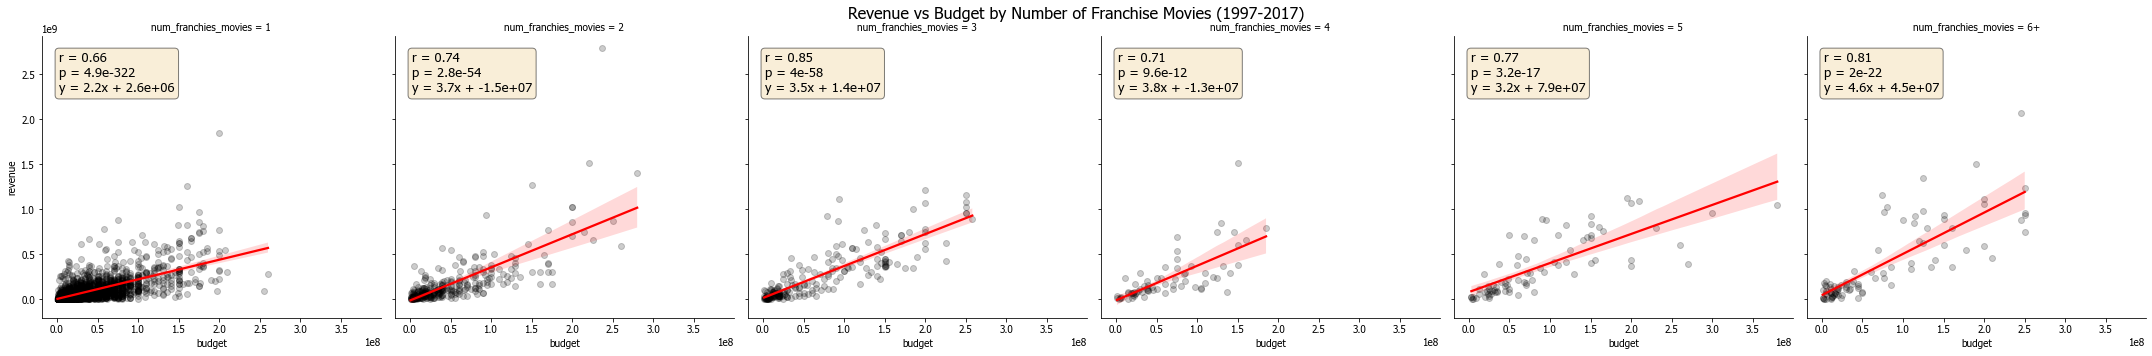

In [48]:
imdb_scoring.loc[imdb_scoring.num_franchies_movies >= 6, 'num_franchies_movies'] = '6+'
imdb_scoring = imdb_scoring.astype({'num_franchies_movies': str})

g = sns.lmplot(x='budget', y='revenue', data=imdb_scoring.sort_values(by = "num_franchies_movies"),
               col='num_franchies_movies', height=5, aspect=1,
               scatter_kws={'alpha':0.2, 'color': 'black'},
               line_kws={'color': 'red'})

plt.rcParams['font.family'] = 'Tahoma'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['budget'], data['revenue'])
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data['budget'], data['revenue'])
    ax = plt.gca()
    ax.text(.05, .8, 'r = {:.2f}\np = {:.2g}\ny = {:.1f}x + {:.2g}'.format(r, p, slope, intercept),
            transform=ax.transAxes,fontsize=13,  bbox=props )
    
g.map_dataframe(annotate) # Runs for each row

# Add title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Revenue vs Budget by Number of Franchise Movies (1997-2017)', fontsize=16)

plt.show()

#### Looking at different genres

In [49]:
genre_scoring = imdb_scoring.copy(deep = True)
genre_scoring = genre_scoring[['title', 'imdb_id', 'revenue', 'budget', 'est_tickets', 'returns_ratio', 'prof_tickets', 'genres']]

genre_scoring['genre_only'] = np.empty((len(genre_scoring), 0)).tolist()

index_i = 0
for i in genre_scoring['genres']:
    if type(i) is tuple:
        for j in i:
            genre_scoring['genre_only'][index_i].append(j['name'])
    elif type(i) is dict:
        genre_scoring['genre_only'][index_i].append(i['name'])
    index_i = index_i + 1

genre_scoring = genre_scoring.drop("genres", axis = 1)

genre_scoring = genre_scoring.set_index(['title','imdb_id','revenue', 'budget', 'est_tickets', 'returns_ratio', 'prof_tickets'])['genre_only'].apply(pd.Series).stack()
genre_scoring = genre_scoring.reset_index()
genre_scoring.columns = ['title','imdb_id','revenue', 'budget', 'est_tickets', 'returns_ratio', 'prof_tickets', 'genre_num','genre_only']

In [50]:
genre_scoring['genre_only'].value_counts()

Drama              1528
Comedy             1192
Thriller            958
Action              932
Adventure           628
Romance             597
Crime               527
Science Fiction     394
Family              376
Fantasy             335
Horror              316
Mystery             285
Animation           228
History             132
War                 108
Music                95
Western              32
Documentary          25
Foreign              17
Name: genre_only, dtype: int64

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3697710700.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3697710700.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


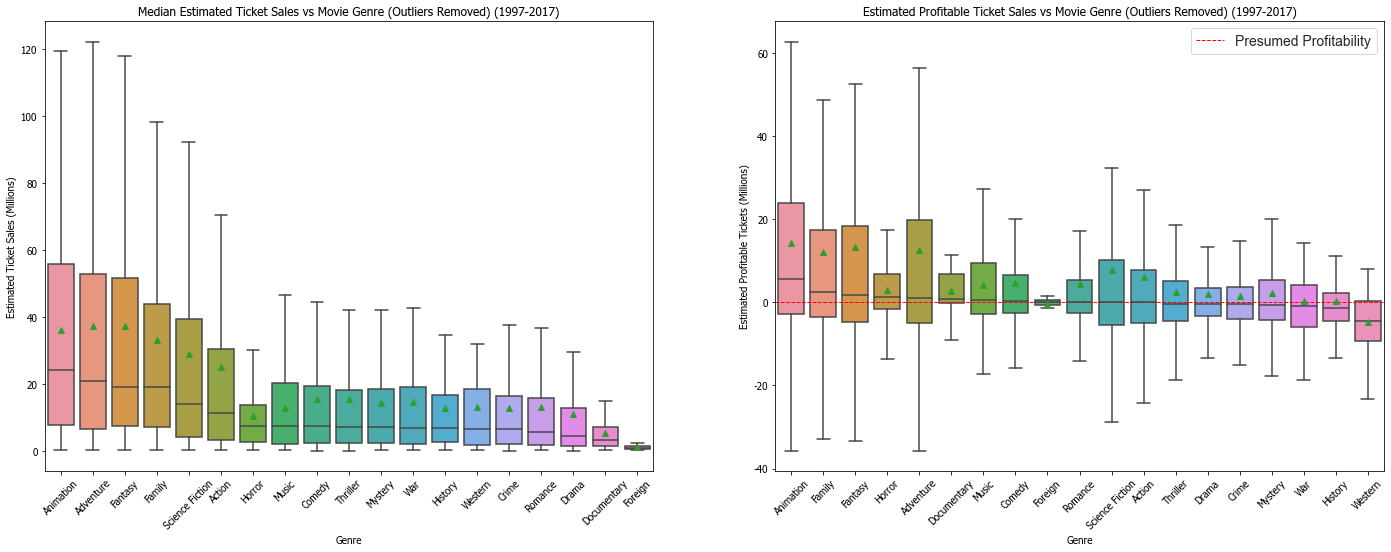

In [51]:
fig, ax = plt.subplots(1,2, figsize=(24,8.27))
sns.set_style("whitegrid")

# Plot ticket sales
plot_order = genre_scoring.groupby(["genre_only"])['est_tickets'].aggregate(np.median).reset_index().sort_values('est_tickets', ascending = False)
sns.boxplot(x="genre_only", y="est_tickets", data=genre_scoring,
                         order=plot_order['genre_only'],
                         #estimator=median,
                         ax = ax[0],
                         showfliers = False, # hides outliers
                         showmeans=True)

ax[0].title.set_text('Median Estimated Ticket Sales vs Movie Genre (Outliers Removed) (1997-2017)')

ax[0].set(xlabel="Genre", ylabel="Estimated Ticket Sales (Millions)")
for item in ax[0].get_xticklabels():
    item.set_rotation(45)

ylabels = ['{:,.0f}'.format(x) for x in ax[0].get_yticks()/1e6]
ax[0].set_yticklabels(ylabels)

    
# Plot Number of Profitable tickets
plot_order = genre_scoring.groupby(["genre_only"])['prof_tickets'].aggregate(np.median).reset_index().sort_values('prof_tickets', ascending = False)
sns.boxplot(x="genre_only", y="prof_tickets", data=genre_scoring,
                         order=plot_order['genre_only'],
                         showfliers = False, # hides outliers
                         ax = ax[1],
                         showmeans=True)
ax[1].title.set_text('Estimated Profitable Ticket Sales vs Movie Genre (Outliers Removed) (1997-2017)', )
ax[1].set(xlabel="Genre", ylabel="Estimated Profitable Tickets (Millions)")
for item in ax[1].get_xticklabels():
    item.set_rotation(45)

ylabels = ['{:,.0f}'.format(x) for x in ax[1].get_yticks()/1e6]
ax[1].set_yticklabels(ylabels)

#ax[1].set_yticks([-1, 1, 3, 5, 7, 9, 11, 13])

# Add line to represent profitability
ax[1].axhline(0.0, color = 'red', linewidth=1, linestyle='--' ,label = "Presumed Profitability")
ax[1].legend(fontsize = 14)

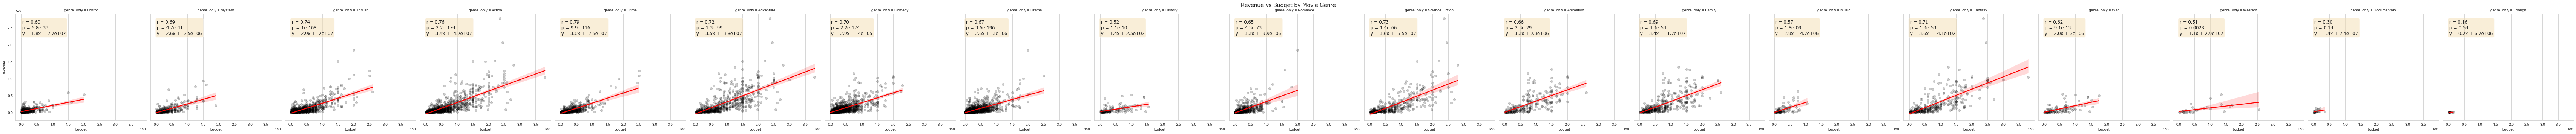

In [52]:
g = sns.lmplot(x='budget', y='revenue', data=genre_scoring,
               col='genre_only', height=5, aspect=1,
               scatter_kws={'alpha':0.2, 'color': 'black'},
               line_kws={'color': 'red'})

plt.rcParams['font.family'] = 'Tahoma'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['budget'], data['revenue'])
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data['budget'], data['revenue'])
    ax = plt.gca()
    ax.text(.05, .8, 'r = {:.2f}\np = {:.2g}\ny = {:.1f}x + {:.2g}'.format(r, p, slope, intercept),
            transform=ax.transAxes,fontsize=13,  bbox=props )
    
g.map_dataframe(annotate) # Runs for each row

# Add title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Revenue vs Budget by Movie Genre', fontsize=16)

plt.show()

## Seasonal release windows

In [53]:
def switcher_month(argument):
    switcher = {
        1: "Jan",
        2: "Feb",
        3: "Mar",
        4: "Apr",
        5: "May",
        6: "Jun",
        7: "Jul",
        8: "Aug",
        9: "Sep",
        10: "Oct",
        11: "Nov",
        12: "Dec"
    }
    return switcher.get(argument, "Invalid month")

# Yearly Windows were decided based on the average proportion of yearly sales for each month
def switcher_window(argument):
    switcher = {
        1: "New Year",
        2: "New Year",
        3: "Spring",
        4: "Spring",
        5: "Summer",
        6: "Summer",
        7: "Summer",
        8: "Fall",
        9: "Fall",
        10: "Fall",
        11: "Holiday",
        12: "Holiday"
    }
    return switcher.get(argument, "Invalid month")

In [54]:
imdb_scoring['release_window'] = np.NaN
imdb_scoring['release_month'] = np.NaN
imdb_scoring['release_year'] = np.NaN

for i in range(len(imdb_scoring['release_date'])):
    imdb_scoring['release_window'][i] = switcher_window(imdb_scoring['release_date'][i].month)
    imdb_scoring['release_month'][i] = switcher_month(imdb_scoring['release_date'][i].month)
    imdb_scoring['release_year'][i] = imdb_scoring['release_date'][i].year

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1394273326.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imdb_scoring['release_window'][i] = switcher_window(imdb_scoring['release_date'][i].month)
/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1394273326.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [55]:
# Calculate what proportion of yearly sales each month made up

# prepare dataframe to store values
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

years = []
for i in range(1997, 2017):
    for j in range(12):
        years.append(i)


sales_by_month = pd.DataFrame(columns=['month','year', 'prop_yearly_sales'])
sales_by_month.month = months * 20
sales_by_month.year = years

# Fill dataframe with values
for i in range(len(sales_by_month)):
    matching_movies = (imdb_scoring['release_month'] == sales_by_month['month'][i]) & (imdb_scoring['release_year']==sales_by_month['year'][i])
    
    sales_by_month['prop_yearly_sales'][i] = (
        sum(imdb_scoring[matching_movies]['revenue']) /
        sum(imdb_scoring['revenue'][imdb_scoring['release_year']==sales_by_month['year'][i]])
    )

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/3537182180.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_by_month['prop_yearly_sales'][i] = (


/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/410512513.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


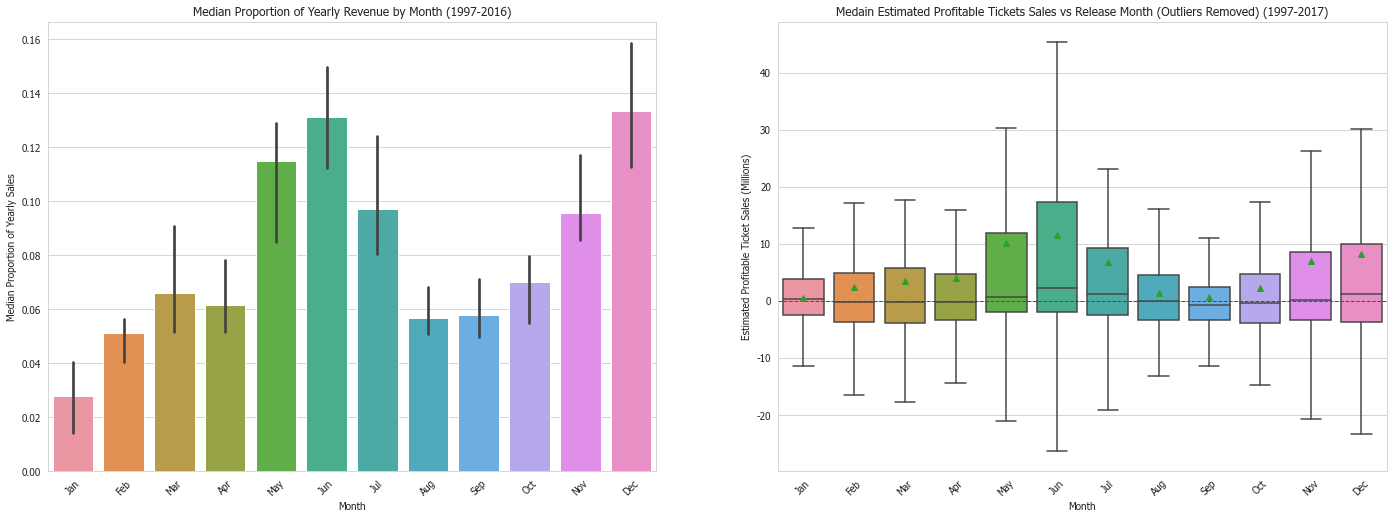

In [56]:
fig, ax = plt.subplots(1,2, figsize=(24,8.27))
sns.set_style("whitegrid")

# Plot Each Month's Average Proporiton of Yearly Sales 
sns.barplot(x="month", y="prop_yearly_sales", data=sales_by_month,
                         #order=plot_order['month'],
                         estimator=median,
                         ax = ax[0])

ax[0].title.set_text('Median Proportion of Yearly Revenue by Month (1997-2016)')

ax[0].set(xlabel="Month", ylabel="Median Proportion of Yearly Sales")
for item in ax[0].get_xticklabels():
    item.set_rotation(45)

    
# Plot 
sns.boxplot(x="release_month", y="prof_tickets", data=imdb_scoring,
                         #order=plot_order['release_month'],
                         ax = ax[1],
                         showfliers = False, # hides outliers
                         showmeans=True)
ax[1].title.set_text('Medain Estimated Profitable Tickets Sales vs Release Month (Outliers Removed) (1997-2017)', )
ax[1].set(xlabel="Month", ylabel="Estimated Profitable Ticket Sales (Millions)")

for item in ax[1].get_xticklabels():
    item.set_rotation(45)
ylabels = ['{:,.0f}'.format(x) for x in ax[1].get_yticks()/1e6]
ax[1].set_yticklabels(ylabels)

# Add line to represent profitability
ax[1].axhline(0.0, color = 'red', linewidth=1, linestyle='--' ,label = "Presumed Profitability")

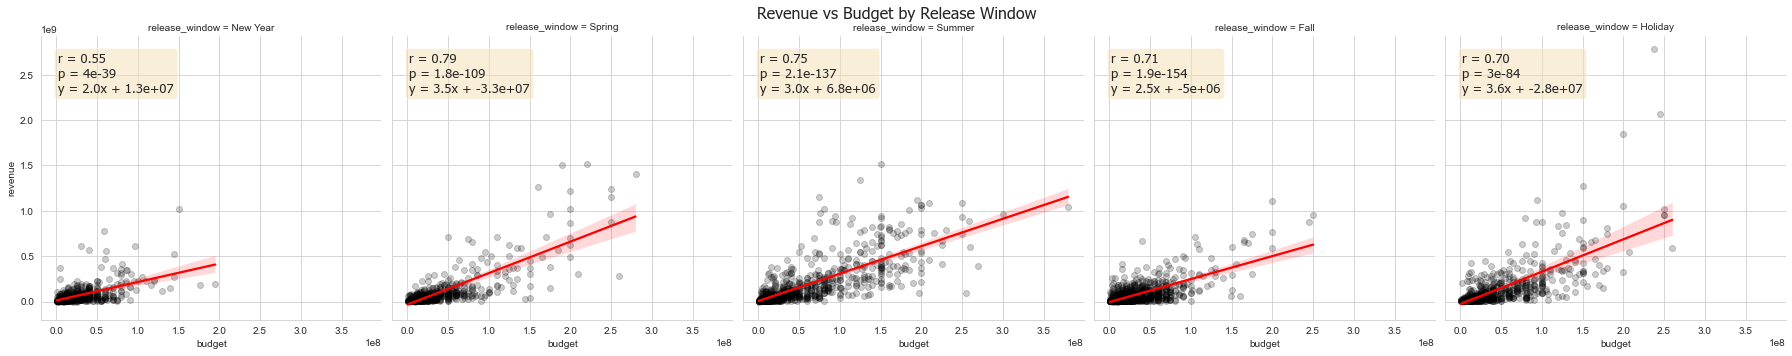

In [57]:
g = sns.lmplot(x='budget', y='revenue', data=imdb_scoring,
               col='release_window', height=5, aspect=1,
               scatter_kws={'alpha':0.2, 'color': 'black'},
               line_kws={'color': 'red'})

plt.rcParams['font.family'] = 'Tahoma'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['budget'], data['revenue'])
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data['budget'], data['revenue'])
    ax = plt.gca()
    ax.text(.05, .8, 'r = {:.2f}\np = {:.2g}\ny = {:.1f}x + {:.2g}'.format(r, p, slope, intercept),
            transform=ax.transAxes,fontsize=13,  bbox=props )
    
g.map_dataframe(annotate) # Runs for each row

# Add title
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('Revenue vs Budget by Release Window', fontsize=16)

plt.show()

#### Examining Production Companies

In [58]:
imdb_scoring.head(1)

,original_title,title,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,vote_bracket,release_window,release_month,release_year
0,The Relic,The Relic,1997-01-10 00:00:00,33956608.0,5.185946e+07,60000000.0,9.163364e+07,-86043392.0,-1.314078e+08,-1.434057,7.397954e+06,1.307190e+07,-1.874584e+07,130.0,5.8,B-,8.0,"({'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","({'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","({'name': 'Paramount Pictures', 'id': 4}, {'na...",A researcher at Chicago's Natural History Muse...,-0.802,The Next Evolution In Terror.,Released,7.699967,11015,tt0120004,NaN,/jD853TWyJYuksMldrFWaXMovRg0.jpg,4.0,New Year,Jan,1997.0


In [59]:
production_scoring = imdb_scoring.copy(deep = True)
production_scoring = production_scoring[['title', 'imdb_id', 'revenue', 'budget', 'est_tickets', 'prof_tickets', 'production_companies']]

production_scoring['production_company'] = np.empty((len(production_scoring), 0)).tolist()

index_i = 0
for i in production_scoring['production_companies']:
    if type(i) is tuple:
        for j in i:
            production_scoring['production_company'][index_i].append(j['name'])
    elif type(i) is dict:
        production_scoring['production_company'][index_i].append(i['name'])
    index_i = index_i + 1

production_scoring = production_scoring.drop("production_companies", axis = 1)

production_scoring = production_scoring.set_index(['title','imdb_id','revenue', 'budget', 'est_tickets', 'prof_tickets'])['production_company'].apply(pd.Series).stack()
production_scoring = production_scoring.reset_index()
production_scoring.columns = ['title','imdb_id','revenue', 'budget', 'est_tickets', 'prof_tickets', 'studio_num','production_company']

In [60]:
#len(list(production_scoring['production_company'].value_counts()))

studio_counts = pd.DataFrame(production_scoring['production_company'].value_counts()).reset_index()
studio_counts = studio_counts.rename(columns={"index": "production_company", "production_company": "num_movies"})
studio_means = production_scoring.groupby('production_company').mean()

studio_means = studio_means.merge(studio_counts, how = 'inner', on = ['production_company', 'production_company'])
studio_means_3_up = studio_means[studio_means['num_movies'] >= 3]

#.sort_values("returns_ratio", ascending = False)

<AxesSubplot:xlabel='budget', ylabel='revenue'>

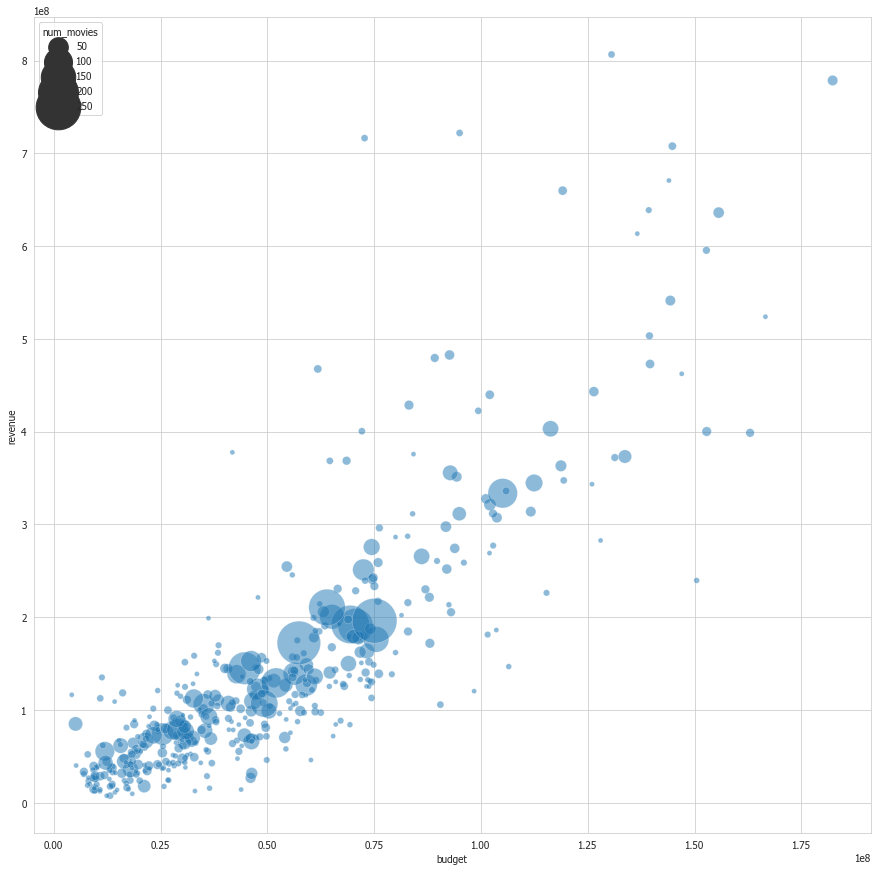

In [61]:
plt.figure(figsize=(15,15))

sns.scatterplot(data = studio_means[studio_means['num_movies'] >= 5],
                size = 'num_movies',
                x = "budget",
                y = "revenue",
                alpha=.5,
                sizes = (25,2000)
               )


/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1240058776.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ylabels)
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1240058776.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(ylabels)


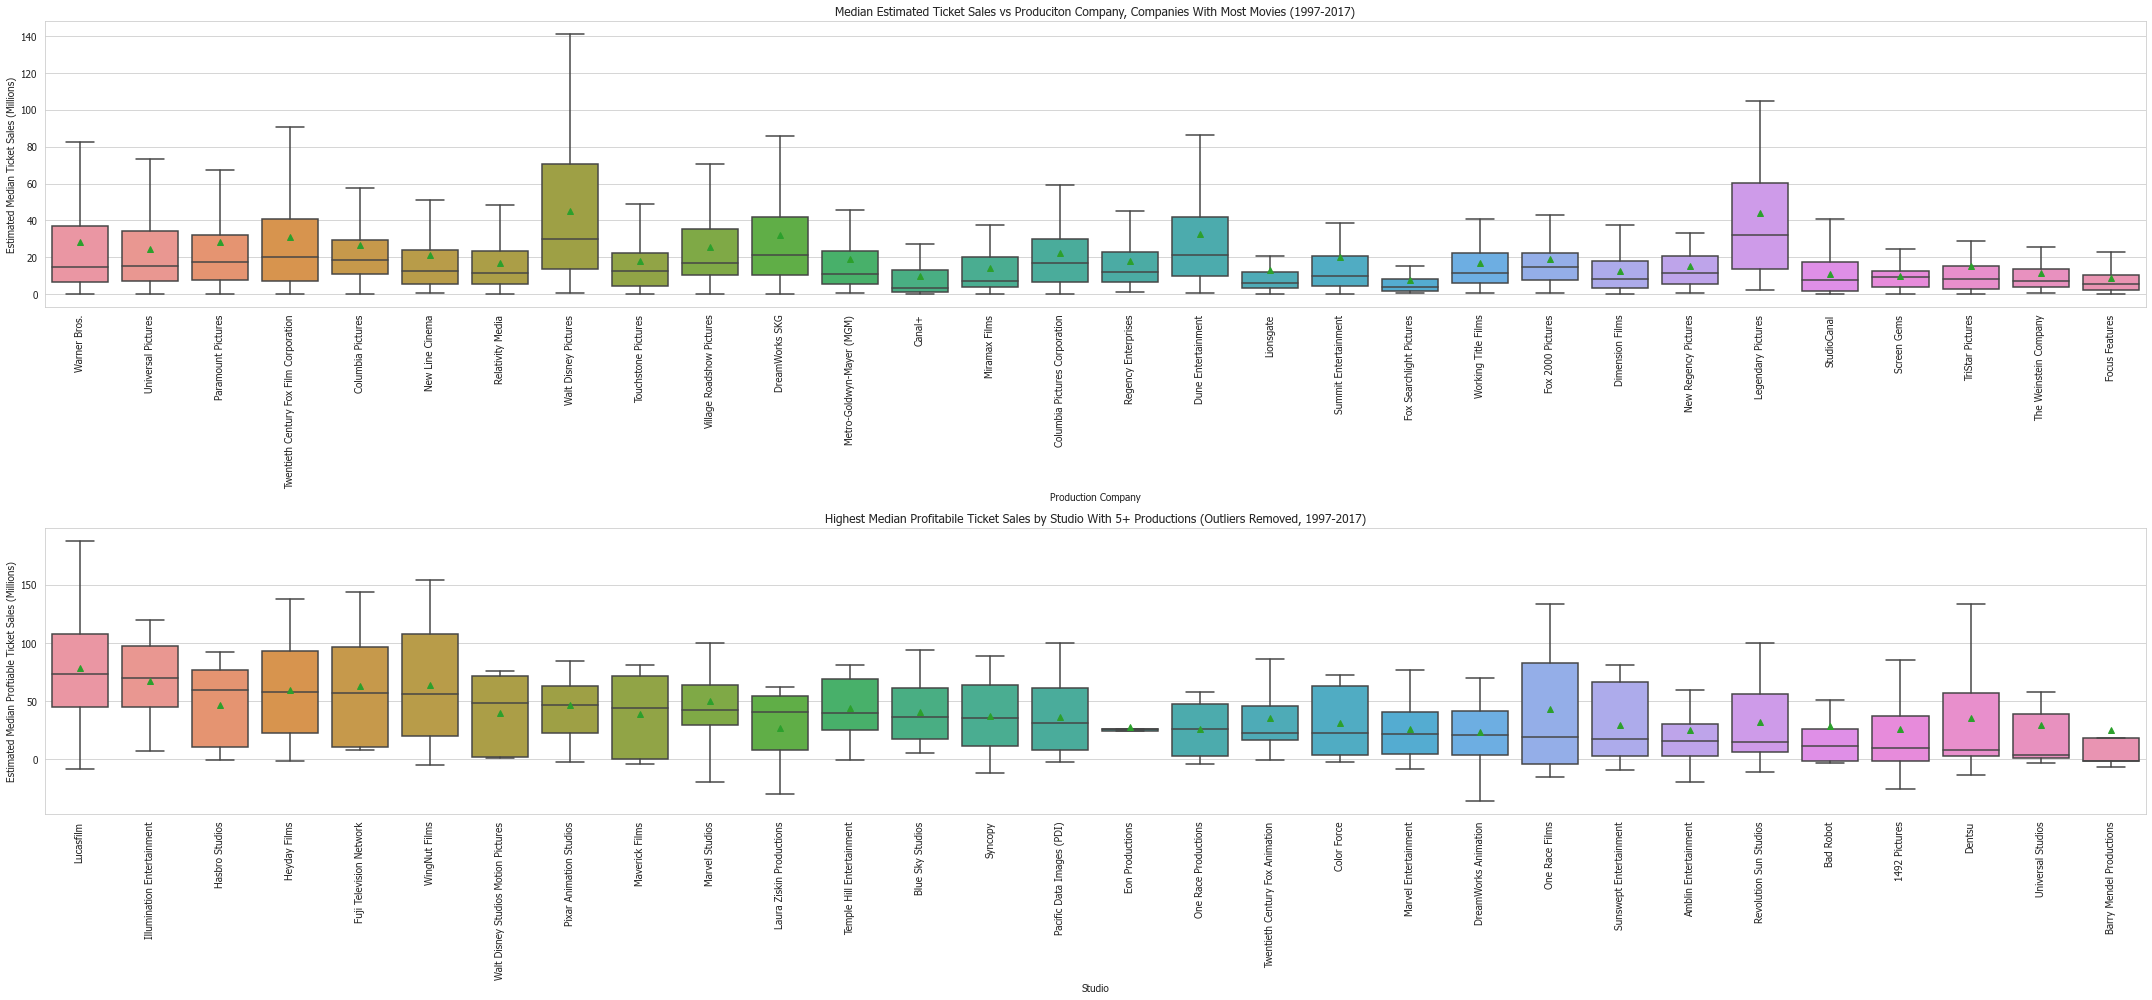

In [62]:
fig, ax = plt.subplots(2,1, figsize=(30,14))
sns.set_style("whitegrid")


biggest_stuidos = list(production_scoring['production_company'].value_counts().head(30)[:].index)
production_scoring_biggest = production_scoring[production_scoring['production_company'].isin(biggest_stuidos)]

# Plot ticket sales
plot_order = production_scoring_biggest.groupby(["production_company"])['est_tickets'].aggregate(np.median).reset_index().sort_values('est_tickets', ascending = False)
sns.boxplot(x="production_company", y="est_tickets", data=production_scoring_biggest,
                         order=biggest_stuidos,
                         #estimator=median,
                         ax = ax[0],
                         showfliers = False,
                         showmeans=True)

ax[0].title.set_text('Median Estimated Ticket Sales vs Produciton Company, Companies With Most Movies (1997-2017)')

ax[0].set(xlabel="Production Company", ylabel="Estimated Median Ticket Sales (Millions)")
for item in ax[0].get_xticklabels():
    item.set_rotation(90)

ylabels = ['{:,.0f}'.format(x) for x in ax[0].get_yticks()/1e6]
ax[0].set_yticklabels(ylabels)

    
#Plot returns ratio
# return_ratio_genre = genre_scoring.copy(deep = True)
# return_ratio_genre['returns_ratio'] = return_ratio_genre['returns_ratio'] - 1.0

most_profitable_studios = list(studio_means[studio_means['num_movies'] >= 5].sort_values('prof_tickets', ascending = False).head(30)['production_company'])
production_scoring_best = production_scoring[production_scoring['production_company'].isin(most_profitable_studios)]

plot_order = production_scoring_best.groupby(["production_company"])['prof_tickets'].aggregate(np.median).reset_index().sort_values('prof_tickets', ascending = False)
sns.boxplot(x="production_company", y="prof_tickets", data=production_scoring_best,
                         order=plot_order['production_company'],
                         showfliers = False, # hides outliers
                         ax = ax[1],
                         showmeans=True)
ax[1].title.set_text('Highest Median Profitabile Ticket Sales by Studio With 5+ Productions (Outliers Removed, 1997-2017)', )
ax[1].set(xlabel="Studio", ylabel="Estimated Median Proftiable Ticket Sales (Millions)")
for item in ax[1].get_xticklabels():
    item.set_rotation(90)

ylabels = ['{:,.0f}'.format(x) for x in ax[1].get_yticks()/1e6]
ax[1].set_yticklabels(ylabels)
# ax[1].axhline(1.00, color = 'red', label = "Presumed Profitability")
# ax[1].legend(fontsize = 14)

fig.tight_layout()

## Building a Linear Model

#### Attach Useful Columns Generated Earlier

In [145]:
vote_release = imdb_scoring.drop(imdb_scoring.columns.difference(['imdb_id', 'release_window', 'vote_bracket']), axis = 1)
c_rank = cinemascore_only.drop(cinemascore_only.columns.difference(['imdb_id', 'cinemascore_rank']), axis = 1)

model_movies = movies.copy(deep = True)
model_movies = pd.merge(left=model_movies, right=vote_release, left_on='imdb_id', right_on='imdb_id')
model_movies = pd.merge(left=model_movies, right=c_rank, left_on='imdb_id', right_on='imdb_id')

# Need to invert ranks to make 5 the best and 1 the worst to work in a linear model
def switcher_invert_ranks(argument):
    switcher = {
        1: 5,
        2: 4,
        3: 3,
        4: 2,
        5: 1,
    }
    return switcher.get(argument, "Invalid month")

for i in range(len(model_movies)):
    model_movies['cinemascore_rank'][i] = switcher_invert_ranks(model_movies['cinemascore_rank'][i])
    model_movies['vote_bracket'][i] = switcher_invert_ranks(model_movies['vote_bracket'][i])

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/4276506681.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_movies['cinemascore_rank'][i] = switcher_invert_ranks(model_movies['cinemascore_rank'][i])
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/4276506681.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_movies['vote_bracket'][i] = switcher_invert_ranks(model_movies['vote_bracket'][i])


In [146]:
model_movies.head()

,original_title,title,release_date,revenue,revenue_adjusted,budget,budget_adjusted,est_profit,est_profit_adjusted,returns_ratio,est_tickets,budget_tickets,prof_tickets,vote_count,vote_average,cinemascore,cinemascore_num,genres,runtime,belongs_to_collection,num_franchies_movies,original_language,spoken_languages,production_countries,production_companies,overview,overview_sentiment,tagline,status,popularity,id,imdb_id,homepage,poster_path,vote_bracket,release_window,cinemascore_rank
0,The Relic,The Relic,1997-01-10 00:00:00,33956608.0,5.185946e+07,60000000.0,9.163364e+07,-86043392.0,-1.314078e+08,-1.434057,7.397954e+06,1.307190e+07,-1.874584e+07,130.0,5.8,B-,8.0,"({'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","({'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","({'name': 'Paramount Pictures', 'id': 4}, {'na...",A researcher at Chicago's Natural History Muse...,-0.8020,The Next Evolution In Terror.,Released,7.699967,11015,tt0120004,NaN,/jD853TWyJYuksMldrFWaXMovRg0.jpg,2.0,New Year,2
1,Turbulence,Turbulence,1997-01-09 00:00:00,11466088.0,1.751132e+07,55000000.0,8.399751e+07,-98533912.0,-1.504837e+08,-1.791526,2.498058e+06,1.198257e+07,-2.146708e+07,63.0,5.2,B-,8.0,"({'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",100.0,"{'id': 166379, 'name': 'Turbulence Collection'...",2,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...","On a flight transporting dangerous convicts, m...",-0.9201,"If you weren't afraid of flying before, you wi...",Released,5.304043,34314,tt0120390,NaN,/n1U5lOvu6wSOQwdgSx2Yh41THdi.jpg,1.0,New Year,2
2,Metro,Metro,1997-01-16 00:00:00,31987563.0,4.885228e+07,55000000.0,8.399751e+07,-78012437.0,-1.191427e+08,-1.418408,6.968968e+06,1.198257e+07,-1.699617e+07,136.0,5.3,B+,10.0,"({'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",117.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'Caravan Pictures', 'id': 175}, {'na...","Roper, a hostage negotiator catches a murderou...",-0.8979,San Francisco's top police hostage negotiator ...,Released,10.519481,8860,tt0119664,NaN,/5fLP5go9bMQImOZUo72YLcHspau.jpg,1.0,New Year,3
3,Dante's Peak,Dante's Peak,1997-02-07 00:00:00,178127760.0,2.720416e+08,116000000.0,1.771584e+08,-53872240.0,-8.227516e+07,-0.464416,3.880779e+07,2.527233e+07,-1.173687e+07,445.0,5.8,A-,11.0,"({'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",108.0,NaN,1,en,"{'iso_639_1': 'en', 'name': 'English'}","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'Universal Pictures', 'id': 33}, {'n...",Volcanologist Harry Dalton comes to the sleepy...,-0.9118,The pressure is building...,Released,7.240753,9619,tt0118928,NaN,/6wBlgo0xqja56OMfQoxsdLmcR76.jpg,2.0,New Year,4
4,Absolute Power,Absolute Power,1997-02-14 00:00:00,50068310.0,7.646570e+07,50000000.0,7.636137e+07,-49931690.0,-7.625705e+07,-0.998634,1.090813e+07,1.089325e+07,-1.087836e+07,226.0,6.4,B+,10.0,"({'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",121.0,NaN,1,en,"({'iso_639_1': 'en', 'name': 'English'}, {'iso...","{'iso_3166_1': 'US', 'name': 'United States of...","({'name': 'Columbia Pictures', 'id': 5}, {'nam...",A master thief coincidentally is robbing a hou...,-0.7650,Corrupts Absolutely.,Released,7.661240,66,tt0118548,NaN,/oJQdp09Oc51DkArsMDvgDLdWiDu.jpg,3.0,New Year,3


#### Drop Unwanted Columns

In [147]:
movie_drops = model_movies.drop(columns = ['original_title', 'title', 'release_date', 'revenue', 'revenue_adjusted', 'budget', 'budget_adjusted',
                 'est_profit', 'est_profit_adjusted', 'returns_ratio',
                 'cinemascore', 'cinemascore_num', 'vote_average', 'belongs_to_collection',
                 'spoken_languages', 'overview', 'vote_count',
                 'overview_sentiment', 'tagline', 'status', 'popularity', 'id', 'imdb_id', 
                 'homepage', 'poster_path'])

movie_drops = movie_drops.drop(columns = 'prof_tickets')
#movie_drops = movie_drops.drop(columns = 'est_tickets')


In [148]:
movie_drops.head(1)

,est_tickets,budget_tickets,genres,runtime,num_franchies_movies,original_language,production_countries,production_companies,vote_bracket,release_window,cinemascore_rank
0,7.397954e+06,1.307190e+07,"({'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",110.0,1,en,"({'iso_3166_1': 'DE', 'name': 'Germany'}, {'is...","({'name': 'Paramount Pictures', 'id': 4}, {'na...",2.0,New Year,2


#### Restructure Data in Some Columns

In [149]:
# Make dictionaries into lists

# production_companies
i_loc = 0
for i in movie_drops['production_companies']:
    if type(i) is tuple:
        #studios = []
        studios = ""
        for j in i:
             #studios.append(j['name'])
            stu = "cp_"+ str(j['name'].replace(" ", "_"))
            studios = studios + stu + " "
        movie_drops['production_companies'][i_loc] = studios.strip().lower()
    elif type(i) is dict:
        #movie_drops['genres'][i_loc] = [movie_drops['genres'][i_loc]['name']]
        movie_drops['production_companies'][i_loc] = "cp_"+str(movie_drops['production_companies'][i_loc]['name'].replace(" ", "_").lower())
    else:
        movie_drops['production_companies'][i_loc] = ""
    i_loc += 1

# Genres
i_loc = 0
for i in movie_drops['genres']:
    if type(i) is tuple:
        #studios = []
        studios = ""
        for j in i:
             #studios.append(j['name'])
            stu = "g_" + str(j['name'].replace(" ", "_"))
            studios = studios + stu + " "
        movie_drops['genres'][i_loc] = studios.strip().lower()
    elif type(i) is dict:
        #movie_drops['genres'][i_loc] = [movie_drops['genres'][i_loc]['name']]
        movie_drops['genres'][i_loc] = "g_"+str(movie_drops['genres'][i_loc]['name'].replace(" ", "_").lower())
    else:
        movie_drops['genres'][i_loc] = ""
    i_loc += 1

# Production Countries
i_loc = 0
for i in movie_drops['production_countries']:
    if type(i) is tuple:
        #studios = []
        studios = ""
        for j in i:
             #studios.append(j['name'])
            stu = "cn_" + str(j['name'].replace(" ", "_"))
            studios = studios + stu + " "
        movie_drops['production_countries'][i_loc] = studios.strip().lower()
    elif type(i) is dict:
        #movie_drops['genres'][i_loc] = [movie_drops['genres'][i_loc]['name']]
        movie_drops['production_countries'][i_loc] = "cn_"+str(movie_drops['production_countries'][i_loc]['name'].replace(" ", "_").lower())
    else:
        movie_drops['production_countries'][i_loc] = ""
    i_loc += 1

/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1790475891.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_drops['production_companies'][i_loc] = studios.strip().lower()
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1790475891.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_drops['production_companies'][i_loc] = "cp_"+str(movie_drops['production_companies'][i_loc]['name'].replace(" ", "_").lower())
/var/folders/vx/5yx19_554d10lxjjq790rwdh0000gn/T/ipykernel_17296/1790475891.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

In [150]:
# Correct incorrect data types
movie_drops['vote_bracket'] = movie_drops['vote_bracket'].astype('int')
#movie_drops['vote_count'] = movie_drops['vote_count'].astype('int')
movie_drops['runtime'] = movie_drops['runtime'].astype('int')
movie_drops['original_language'] = movie_drops['original_language'].astype('str')
movie_drops['release_window'] = movie_drops['release_window'].astype('str')
movie_drops['genres'] = movie_drops['genres'].astype(str)
#movie_drops['production_countries'] = movie_drops['production_countries'].astype(str)
#movie_drops['production_companies'] = movie_drops['production_companies'].astype(str)

In [151]:
movie_drops = movie_drops.drop('production_companies', axis = 1)
movie_drops = movie_drops.drop('production_countries', axis = 1)
movie_drops = movie_drops.drop('original_language', axis = 1)
#movie_drops = movie_drops.drop('cinemascore_rank', axis = 1)

In [152]:
movie_drops.head(2)

,est_tickets,budget_tickets,genres,runtime,num_franchies_movies,vote_bracket,release_window,cinemascore_rank
0,7.397954e+06,1.307190e+07,g_horror g_mystery g_thriller,110,1,2,New Year,2
1,2.498058e+06,1.198257e+07,g_action g_thriller g_crime,100,2,1,New Year,2


In [153]:
movie_drops.dtypes

est_tickets             float64
budget_tickets          float64
genres                   object
runtime                   int64
num_franchies_movies      int64
vote_bracket              int64
release_window           object
cinemascore_rank          int64
dtype: object

### Setup Machine Learning Dataframes and Preprocessing

In [154]:
train_df, test_df = train_test_split(movie_drops, test_size=0.25, random_state=123)

In [155]:
# X_train, y_train = train_df.drop(columns=['prof_tickets']), train_df['prof_tickets']
# X_test, y_test = test_df.drop(columns=['prof_tickets']), test_df['prof_tickets']

X_train, y_train = train_df.drop(columns=['est_tickets']), train_df['est_tickets']
X_test, y_test = test_df.drop(columns=['est_tickets']), test_df['est_tickets']

In [156]:
X_train.head(1)

,budget_tickets,genres,runtime,num_franchies_movies,vote_bracket,release_window,cinemascore_rank
878,1.297710e+07,g_adventure g_animation g_family,83,4,3,Fall,4


In [157]:
# categorical_features = ['original_language', 'release_window']
categorical_features = ['release_window']
binary_features = []
list_features = ['genres', "production_countries", "production_companies"]
genre_features = 'genres'

numeric_features = list(
    set(X_train.columns)
    - set(categorical_features)
    - set(list_features)
    - set(genre_features)
)

preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(handle_unknown="ignore"), categorical_features),
    (CountVectorizer(lowercase=True), "genres"),
    #(CountVectorizer(lowercase=True), "production_countries"),
    #(CountVectorizer(lowercase=True), "production_companies"),
    #(MultiLabelBinarizer(classes = possible_genres), ['genres']),
    #(MultiHotEncoder(), ["production_countries", "genres", "production_companies"]),
)

In [158]:
numeric_features

['runtime',
 'budget_tickets',
 'vote_bracket',
 'num_franchies_movies',
 'cinemascore_rank']

In [159]:
#CountVectorizer(tokenizer=lambda doc: doc, lowercase=False).fit_transform(X_train['genres']).toarray()

# from sklearn.preprocessing import MultiLabelBinarizer
# mlb = MultiLabelBinarizer()
# n = mlb.fit_transform(X_train['original_language'])

In [160]:
preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['runtime', 'budget_tickets', 'vote_bracket',
                                  'num_franchies_movies', 'cinemascore_rank']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['release_window']),
                                ('countvectorizer', CountVectorizer(),
                                 'genres')])

In [161]:
#OneHotEncoder(handle_unknown="ignore").fit_transform(list(X_train['original_language']))

In [164]:
linear_reg_pipe = make_pipeline(
    preprocessor, LinearRegression(fit_intercept=True)
)

pd.DataFrame(
    cross_validate(
        linear_reg_pipe,
        X_train,
        y_train,
        return_train_score=True
    )
).mean()


fit_time       0.016646
score_time     0.006641
test_score     0.574570
train_score    0.596441
dtype: float64

In [178]:
import sklearn.metrics as metrics

y_pred = linear_reg_pipe.predict(X_test)

In [180]:
mse = metrics.mean_squared_error(y_test, Y_pred)
mse

435244904744954.56

In [165]:
linear_reg_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['runtime', 'budget_tickets',
                                                   'vote_bracket',
                                                   'num_franchies_movies',
                                                   'cinemascore_rank']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['release_window']),
                                                 ('countvectorizer',
                                                  CountVectorizer(),
                                                  'genres')])),
                ('linearregression', LinearRegression())])

In [166]:
linear_reg_pipe.fit(X_train, y_train)

# ALWAYS MAKE SURE FEATURE STEPS ARE THE SAME AS IN THE COLUMN TRANSFORMER

feature_names = (
    numeric_features 
    + list(
        linear_reg_pipe.named_steps["columntransformer"]
        .named_transformers_["onehotencoder"]
        .get_feature_names()
    )
    + list(
        linear_reg_pipe.named_steps["columntransformer"]
        .named_transformers_["countvectorizer"]
        .get_feature_names()
    )
#     + list(
#         linear_reg_pipe.named_steps["columntransformer"]
#         .named_transformers_["countvectorizer-2"]
#         .get_feature_names()
#     )
#     + list(
#         linear_reg_pipe.named_steps["columntransformer"]
#         .named_transformers_["countvectorizer-3"]
#         .get_feature_names()
#     )
)

data = {
    "coefficient (million)": linear_reg_pipe.named_steps["linearregression"].coef_.tolist(),
#     "magnitude": np.absolute(
#         linear_reg_pipe.named_steps["linearregression"].coef_.tolist()
#     ),
}
coef_df = pd.DataFrame(data, index=feature_names).sort_values(
    "coefficient (million)", ascending=False
)

coef_df['coefficient (million)'] = coef_df['coefficient (million)']/1e6

/Users/mpin/opt/miniconda3/envs/movie_EDA/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [167]:
genre_rows = [s for s in coef_df.index[:] if "g_" in s]
genre_weights = coef_df.loc[genre_rows, :]
genre_weights

,coefficient (million)
g_animation,9.207307
g_fantasy,7.310636
g_horror,5.205631
g_comedy,2.484575
g_adventure,1.761620
g_romance,1.705386
g_science_fiction,1.292311
g_mystery,0.539655
g_thriller,0.007365
g_crime,-1.691048


In [168]:
season_rows = [s for s in coef_df.index[:] if "x0_" in s]
season_weights = coef_df.loc[season_rows, :]
season_weights

,coefficient (million)
x0_Summer,2.931551
x0_Holiday,0.575621
x0_New Year,-0.355728
x0_Spring,-0.454009
x0_Fall,-2.697435


In [169]:
other_rows = [s for s in coef_df.index[:] if "x0_" not in s]
other_rows = [s for s in other_rows if "g_" not in s]
other_weights = coef_df.loc[other_rows, :]
other_weights
#season_rows = [s for s in coef_df.index[:] if "x0_" in s]

,coefficient (million)
budget_tickets,14.128999
num_franchies_movies,5.266674
vote_bracket,5.093417
cinemascore_rank,4.950182
runtime,2.436764


In [170]:
coef_df.sort_values("coefficient (million)", ascending = False)

,coefficient (million)
budget_tickets,14.128999
g_animation,9.207307
g_fantasy,7.310636
num_franchies_movies,5.266674
g_horror,5.205631
vote_bracket,5.093417
cinemascore_rank,4.950182
x0_Summer,2.931551
g_comedy,2.484575
runtime,2.436764
